In [5]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime, date
# using literal_eval to ensure lists in Address (that were created in Assignment 1 are correctly interpreted by pandas)
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn import metrics
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
# from sklearn.tree import export_graphviz
# import graphviz
# from graphviz import Source

%matplotlib inline

## Part 1

<b>Recap from Homework 1 & loading in dataset</b>

Following on from assignment 1, I saved a version of my final dataset that has been cleaned, transformed and updated with extra features (both from external sources and deriving new features from existing ones). Below I have outlined the key points from the dataset I will use:
- 2 duplicate rows were removed from the initial 10,000 provided to result in 9,998.
- There are now 15 columns, 6 extra compared to the initial dataset
- The address feature was transformed into comma separated lists for each row. This allowed the extraction of more Postal Codes as well as the Town the property is situated in. As mentioned in Assignment 1, I acknowledge there may still be many gaps where properties in a town or a Dublin Postal Code are not recognised as such.
- A 'CleanedPrice(€)' column was created, which is a copy of the 'Price(€)' column, but with certain block purchases (more than 1 property in the sale) removed, as well as those that are 2 standard deviations above the mean of the logged price of the County the property is situated in.
- A 'Town' column was created, extracted using data from the Address column
- A 'StockPrice' column was created, which gives the closest S&P500 close price to the date of sale.
- A 'Population' column was created, which gives the population of the Town the property is situated in
- 'quarter' & 'QuarterNumber' columns were created from the DateofSale column which give details of the quarter the property was sold in. I will drop 'QuarterNumber'. The only trend I observed with QuarterNumber in Homework 1 was that more properties were sold in later quarters of the year, with no observable difference in the price. It may be useful to treat the Date sold as a categorical feature (i.e. using the quarter) as opposed to continuous, which I will investigate below.

To recap, a summary of the data quality plan completed in Homework 1 is below.

| Feature                    | Issue Description           | Chosen Solution              |
|------------------------------------|-------------------------------|--------------------------------|
| Address                          | Addresses in current format have little value                         | Change format to list to allow for information extraction                           |
| Postal Code                   | Missing Postal Codes| Extract Postal Codes from the Address Field using lists  |
| Postal Code                    | Some Dublin Postal Codes are not in Dublin             | Remove Postal Code from the rows    |
| Property Size Description                        | Missing Property Size Descriptions                       | No action                           |
| Property Size Description                   | Duplicated Property Size Description Category                | Merge categories                      |
| VAT Exclusive                 | Not all new build properties are inclusive of VAT               | Add VAT to properties exclusive of VAT|
| Not Full Market Price                       | Some prices not at market value              | No action     |
| Price (€)                       | Dataset contains block purchases              | Remove properties identified as duplicates from a new price column                   |
| Price (€)                  | Prices are not normalised - significant outliers|Remove log prices that are 2 standard deviations above the mean of each county     |


In [2]:
# use commas as separator
# using converters argument so that Address field maintains lists from Assignment 1
clean_df = pd.read_csv('datasets/PPRFileFinalVersion.csv', keep_default_na=True, delimiter=',', skipinitialspace=True, converters={'Address': literal_eval})

Drop 'QuarterNumber' column and convert remaining columns to appropriate types.

In [3]:
# dropping quarter number
clean_df = clean_df.drop(columns=['QuarterNumber'])

# converting quarter back to a Period datatype (info was lost loading dataset in)
clean_df['quarter'] = pd.to_datetime(clean_df['quarter']).dt.to_period('Q')

# converting to datetime and specifying the day comes first in original data
clean_df['DateofSale(yyyy-mm-dd)'] = pd.to_datetime(clean_df['DateofSale(yyyy-mm-dd)'], dayfirst=True)
clean_df['DateofSale(yyyy-mm-dd)'] = clean_df['DateofSale(yyyy-mm-dd)'].astype('datetime64[ns]')

categorical_cols = ["PostalCode", "County", "NotFullMarketPrice", "VATExclusive", 
                    "DescriptionofProperty", "PropertySizeDescription", "Town"]
for feature in categorical_cols:
    clean_df[feature] = clean_df[feature].astype('category')

In [4]:
# number of rows + columns
print("This dataset has", clean_df.shape[0], "rows and", clean_df.shape[1], "columns")

This dataset has 9998 rows and 14 columns


In [5]:
clean_df.head()

,DateofSale(yyyy-mm-dd),Address,PostalCode,County,Price(€),NotFullMarketPrice,VATExclusive,DescriptionofProperty,PropertySizeDescription,CleanedPrice(€),Town,StockPrice,Population,quarter
0,2017-08-01,"[apartment 27, galway bay sea view apts, sal...",NaN,Galway,90575.00,No,No,New Dwelling house /Apartment,between 38 and 125 sq metres,90575.00,NaN,2476.35,NaN,2017Q3
1,2017-08-28,"[38a lr beechwood ave, ranelagh, dublin 6]",Dublin 6,Dublin,515000.00,No,No,Second-Hand Dwelling house /Apartment,NaN,515000.00,NaN,2444.24,NaN,2017Q3
2,2010-06-17,"[4 ard na greine, lis na dara, dundalk]",NaN,Louth,347066.11,No,Yes,New Dwelling house /Apartment,greater than or equal to 125 sq metres,347066.11,Dundalk,1116.04,39004.0,2010Q2
3,2020-12-18,"[1 cathedral view court, off new st, dublin 8]",Dublin 8,Dublin,345000.00,No,No,Second-Hand Dwelling house /Apartment,NaN,345000.00,NaN,3709.41,NaN,2020Q4
4,2019-02-08,"[190 ardmore dr, artane, dublin 5]",Dublin 5,Dublin,390000.00,No,No,Second-Hand Dwelling house /Apartment,NaN,390000.00,NaN,2707.88,NaN,2019Q1


As allowed for in the brief of this assignment, the dataset I am using was cleaned in Assignment 1. However, although dealing with the issues correctly, I had been slow to drop columns and rows that were either unhelpful, or contained lots of missing data. For the purposes of prediction, I will now either rule out and drop columns that will not be helpful for this task, or replace NaN values with 'Unknown'.

<b>Address</b><br>
I discussed in my Homework 1 solution that due to the inconsistent format of the address field it is quite difficult to split it into meaningful data. For example, some address fields end with the town, some with the county, some with the postal code - some have far more fields than others. It would be technically possible to just split based on commas and say that the second field is the town for example, however this would be incorrect for a large number of properties. I have already used the address field for multiple purposes in Homework 1:

- I extracted the Postal Code for 190 properties that were missing this value in the 'PostalCode' column
- I extracted the Towns for as many properties as possible, splitting those that were classified into 25 different towns as well as another 'Small Towns' category which includes towns that had less than 50 properties in them in the original dataset. This was an arbitrarily chosen number, but it should be appropriate to model all small towns as having the same property pricing characteristics.
- Helped eliminate block property purchases from consideration in the 'CleanedPrice(€)' column. By searching for key words such as 'inclusive' and 'units' I found 11 entries that were clearly relating to the sale of more than 1 property, and thus should not be considered.

By my above logic I have extracted as much information as possible from the 'Address' column. Therefore I shall now remove it from the dataframe.

In [6]:
# dropping Address as per above rationalisation
clean_df = clean_df.drop(columns=['Address'])

<b>PostalCode</b><br>
As discussed in Homework 1, the postal code is missing values for a considerable number of properties. This number was reduced for 190 properties in my solution, but still data is only present for properties in Dublin, and not all of them at that. However, this should still remain a very good indicator of price for those that do have the data populated, as it is a well discussed topic that postal code impacts price (this was also explored in Homework 1). For the purposes of modelling therefore, I will need to replace 'NaN's with with 'Unknown'.

In [7]:
# replacing NaN with 'Unknown'
clean_df['PostalCode'] = clean_df['PostalCode'].cat.add_categories('Unknown')
clean_df['PostalCode'] = clean_df['PostalCode'].fillna('Unknown')

<b>Price(€)</b><br>
In Homework 1 I made a new column called CleanedPrice(€). In this I added all entries from Price(€) and then removed outliers (as defined by a property that was 2 standard deviations above the mean in the county it was situated in). This removed values for 167 outliers, which in turn reduced the observed standard deviation in Price by over 66%. I also removed 11 prices that related to the sale of more than 1 property. Therefore, Price(€) can be dropped alongside any rows that do not have a value for CleanedPrice(€), which is the new target variable.

For the sake of clarity, I will also rename the CleanedPrice(€) column back to Price(€), as this is the name for the target feature that will be used when predicting prices for new test datasets.

In [8]:
# drop price column
clean_df = clean_df.drop(columns=['Price(€)'])
# drop rows without a CleanedPrice(€)
initial = clean_df.shape[0]
clean_df = clean_df.dropna(subset=['CleanedPrice(€)'])
after = clean_df.shape[0]
print(initial-after, "rows were deleted.")

178 rows were deleted.


In [9]:
# rename CleanedPrice(€) back to the original Price(€)
clean_df.rename(columns={'CleanedPrice(€)':'Price(€)'},inplace=True)

<b>VATExclusive</b><br>
In Homework 1 I transformed the Price field of those properties that were VAT exclusive to increase by 13.5%, to make all properties comparable. VATExclusive now only indicates whether or not the associated price used to contain VAT or not, therefore making this feature irrelevant and fit to be dropped. 

In [10]:
# dropping VATExclusive
clean_df = clean_df.drop(columns=['VATExclusive'])

<b>PropertySizeDescription</b><br>
Many properties (almost 90%) do not contain a value for this category. I will convert the missing values to 'Unknown', but keep in mind that this may not be a good feature to use for modelling purposes due to the lack of data.

In [11]:
clean_df['PropertySizeDescription'] = clean_df['PropertySizeDescription'].cat.add_categories('Unknown')
clean_df['PropertySizeDescription'] = clean_df['PropertySizeDescription'].fillna('Unknown')

<b>Town</b><br>
In Homework 1 I obtained the town that the property is located in for almost 40% of the dataset. It will be interesting to explore if this is useful for prediction purposes. I will set the NaN values in this column to 'Unknown' to allow this to happen.

In [12]:
clean_df['Town'] = clean_df['Town'].cat.add_categories('Unknown')
clean_df['Town'] = clean_df['Town'].fillna('Unknown')

<b>Population</b><br>

In [13]:
popMissing = round(clean_df['Population'].isnull().sum()/clean_df.shape[0] * 100, 2)
print(str(popMissing) + "% of entries are missing a town population value")

74.2% of entries are missing a town population value


The population category was an extra feature added at the end of Homework 1. As it was not possible to obtain the town of every property (due to lack of data in the Address field and the fact not every property is in a town) it means that only about 25% of the dataframe has an associated population. As this is a continuous feature I cannot fill the blanks with 'Unknown' and will instead look at the following options:

1) Drop the feature<br>
2) Impute missing values with the median<br>
3) Impute missing values with the mean

I will now create 2 columns to represent options 2 and 3 above, before looking at correlations.

In [14]:
# 2. Impute median
clean_df['PopulationMedian'] = clean_df['Population'].fillna(clean_df['Population'].median()).astype('int64')
# 3. Impute mean
clean_df['PopulationMean'] = clean_df['Population'].fillna(clean_df['Population'].mean()).astype('int64')

In [15]:
# looking at correlations between the 3 pop columns and the target feature (price)
Populations_corr = clean_df[['PopulationMedian','PopulationMean','Population', 'Price(€)']].corr()
Populations_corr

,PopulationMedian,PopulationMean,Population,Price(€)
PopulationMedian,1.000000,0.931403,1.000000,0.164926
PopulationMean,0.931403,1.000000,1.000000,0.213016
Population,1.000000,1.000000,1.000000,0.470431
Price(€),0.164926,0.213016,0.470431,1.000000


The most promising feature based on correlation is the raw Population feature, with a correlation of 0.47, implying a reasonably strong relationship between the population of a town and the prices people pay for the properties. Unfortunately this cannot be used as it contains so many NaN values.

Substituting the missing values with the mean offers the closest correlation with the target as the original. For this reason I will keep PopulationMean for further exploration, and discard the others. I will then rename it back to Population.

In [16]:
clean_df = clean_df.drop(columns=['PopulationMedian','Population'])

# rename PopulationMean back to the original Population
clean_df.rename(columns={'PopulationMean':'Population'},inplace=True)

<b>NotFullMarketPrice</b><br>
As observed in Homework 1 there was a substantial difference in price distribution for properties that received a fair market price versus those that did not. The reasons for a property not being sold for full market price are numerous, however it is fair to say that the reasons do not extend to those that would be naturally predictable, and instead relate to individual circumstance. For that reason I will not consider any property that was sold for below market price in my modelling and will drop the associated rows as well as the feature.

In [17]:
initial = clean_df.shape[0]
clean_df = clean_df[clean_df["NotFullMarketPrice"].str.contains("Yes") == False]
after = clean_df.shape[0]
print(initial-after, "rows were deleted.")
clean_df = clean_df.drop(columns=['NotFullMarketPrice'])

454 rows were deleted.


In [18]:
# number of rows + columns
print("There are now", clean_df.shape[0], "rows and", clean_df.shape[1], "columns")

There are now 9366 rows and 10 columns


Now that all NaN values have been dealt with, and the relevant columns removed, I will move on to model training.

### 1.1 Split dataset into training and testing

What follows throughout the rest of this notebook are various modelling implementations, all ultimately aiming to predict the property price.

The below cell shuffles the dataframe. However it is commented out as it is shuffled using the train_test_split below.

In [19]:
# shuffle data using sklearn.utils shuffle method
#clean_df = pd.DataFrame(data=shuffle(clean_df.values, random_state = 20), 
#                         columns = clean_df.columns).reset_index(drop=True)
clean_df.head()

,DateofSale(yyyy-mm-dd),PostalCode,County,DescriptionofProperty,PropertySizeDescription,Price(€),Town,StockPrice,quarter,Population
0,2017-08-01,Unknown,Galway,New Dwelling house /Apartment,between 38 and 125 sq metres,90575.00,Unknown,2476.35,2017Q3,216229
1,2017-08-28,Dublin 6,Dublin,Second-Hand Dwelling house /Apartment,Unknown,515000.00,Unknown,2444.24,2017Q3,216229
2,2010-06-17,Unknown,Louth,New Dwelling house /Apartment,greater than or equal to 125 sq metres,347066.11,Dundalk,1116.04,2010Q2,39004
3,2020-12-18,Dublin 8,Dublin,Second-Hand Dwelling house /Apartment,Unknown,345000.00,Unknown,3709.41,2020Q4,216229
4,2019-02-08,Dublin 5,Dublin,Second-Hand Dwelling house /Apartment,Unknown,390000.00,Unknown,2707.88,2019Q1,216229


In [20]:
# setting random state to 0 as does not matter that order is the same each time once its shuffled
# setting test_size to 30%
# using sklearns train_test_split method
train, test = train_test_split(clean_df, test_size=0.3, random_state=0)

In [21]:
# resetting the indexes of both to start at 0 (preserves order generated above)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [22]:
print("Training dataset has", train.shape[0], "rows and test dataset has", test.shape[0], "rows.")

Training dataset has 6556 rows and test dataset has 2810 rows.


In [23]:
# verify datatypes have remained intact
train.dtypes

DateofSale(yyyy-mm-dd)     datetime64[ns]
PostalCode                       category
County                           category
DescriptionofProperty            category
PropertySizeDescription          category
Price(€)                          float64
Town                             category
StockPrice                        float64
quarter                     period[Q-DEC]
Population                          int64
dtype: object

### 1.2
### Continuous Features

Originally there were only 2 continuous features in the dataset, Date of Sale and Price (the target). There are now two additional features, StockPrice and Population. I will individually investigate each features relationship with the target to see if there is any observable relationship.

Firstly, I will check the correlation of each feature with the target.

In [24]:
corr = train[['DateofSale(yyyy-mm-dd)','StockPrice','Population', 'Price(€)']]
# changing date of sale to ordinal so it is possible to produce a correlation
corr['DateofSale(yyyy-mm-dd)'] = pd.to_datetime(corr['DateofSale(yyyy-mm-dd)']).apply(lambda date: date.toordinal())
# looking at correlations between the 3 numerical columns and the target feature (price)
continuous_corr = corr.corr()
continuous_corr

/var/folders/sk/nrbzmqq1715frfmf08t0c02c0000gn/T/ipykernel_31918/2467137927.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr['DateofSale(yyyy-mm-dd)'] = pd.to_datetime(corr['DateofSale(yyyy-mm-dd)']).apply(lambda date: date.toordinal())


,DateofSale(yyyy-mm-dd),StockPrice,Population,Price(€)
DateofSale(yyyy-mm-dd),1.000000,0.941402,0.034473,0.187078
StockPrice,0.941402,1.000000,0.034124,0.193034
Population,0.034473,0.034124,1.000000,0.218074
Price(€),0.187078,0.193034,0.218074,1.000000


Reviewing the correlations it is somewhat surprising to observe only weakly positive correlations with the target variable, price. Below are some key observations:

- <b>Price vs Date of Sale (0.19):</b> Knowing that prices have generally risen since the beginning of the time period led me to expect a slightly stronger relationship. However, I think this can be attributed to the fact that there is considerable variability between individual days leading to a much too nuanced relationship that could be captured over such a small window. Perhaps viewing Date as a categorical feature, grouping days into period, may lead to a clearer relationship.
- <b>Price vs Stock Price (0.19):</b> Given that we would generally observe stock prices and property prices to rise in tandem over time, and generally follow the same trend (albeit with property prices lagged) it was also surprising to see the weak relationship. For the same reason as Price vs Date however, I think this can be clearly understood.
- <b>Population vs Price (0.22):</b> Another feature that I would have expected to observe having a stronger relationship with Price, generally noting that more populated areas tend to have higher prices. However, there are 2 key reasons I believe lead to the weak relationship. 1) Data is missing for the vast majority of entries meaning there is a smaller sample size. 2) Only those entries where I identified the property as being situated in a town were assigned a population. This means it is only those places that were located in large towns in the first place were given this piece of information, meaning that it would actually be unreasonable to expect a strong relationship. It would be more interesting to investigate this feature with more complete data.
- <b>Stock Price vs Date (0.94):</b> an extremely strong positive relationship, unsurprising given the bull market that has been experienced for equities since the beginning of this dataset. This also implies that the Stock Price does not offer much information that is already provided by Date, and may instead simply introduce noise to predictions.
- <b>Population vs Date (0.03):</b> essentially no relationship observed, what you would expect given that the population of the towns were obtained from the most recent census results and do not change over time.

<b>DateofSale(yyyy-mm-dd) & Price</b>

/var/folders/sk/nrbzmqq1715frfmf08t0c02c0000gn/T/ipykernel_31918/2057575677.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newlabels)


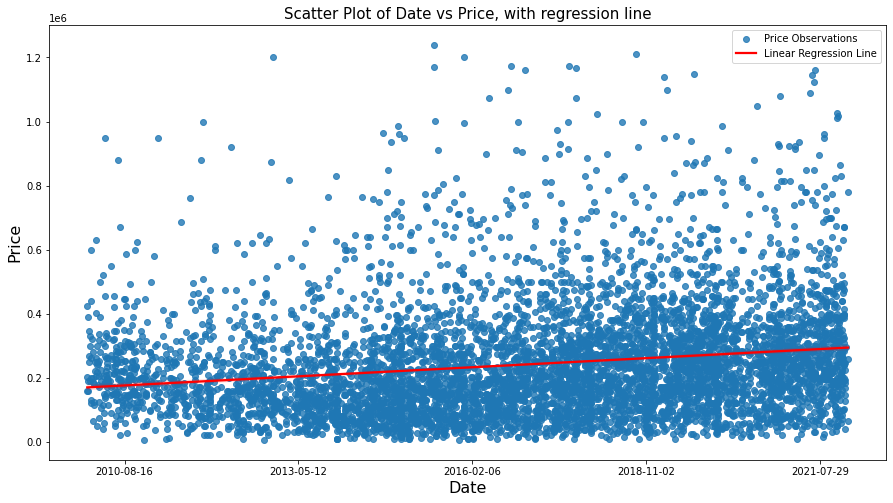

In [25]:
# code for the below inspired from https://stackoverflow.com/questions/29308729/how-to-plot-a-linear-regression-with-datetimes-on-the-x-axis
plt.figure(figsize=(15,8))
ax = sns.regplot(
    x=pd.to_datetime(train['DateofSale(yyyy-mm-dd)']).apply(lambda date: date.toordinal()),
    y=train['Price(€)'], line_kws={"color": "red"}
)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.title("Scatter Plot of Date vs Price, with regression line", fontsize=15)
newlabels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(newlabels)
plt.legend(labels=["Price Observations","Linear Regression Line"])
plt.show()

It is clear that there is a general trend of prices rising as time goes by, and indeed there is also a weakly positive correlation. This makes sense as it is a well known phenomenon that house prices have risen substantially since the beginning of this dataset. It would be possible to make the Date an ordinal continuous feature, incrementing each successive day by 1 from the beginning of the dataset. However, this would be very granular and indicate that there ought to be a difference in price from one day to the next. Typically house prices are viewed on a quarterly or yearly basis - with more of a categorical spin on the time period. I will therefore investigate the 'quarter' feature that was created using DateofSale(yyyy-mm-dd) in Homework1.

<b>Include in model?</b> No

In [26]:
# do not need this feature any more
train = train.drop(columns=['DateofSale(yyyy-mm-dd)'])
test = test.drop(columns=['DateofSale(yyyy-mm-dd)'])

<b>Stock Price & Price</b>

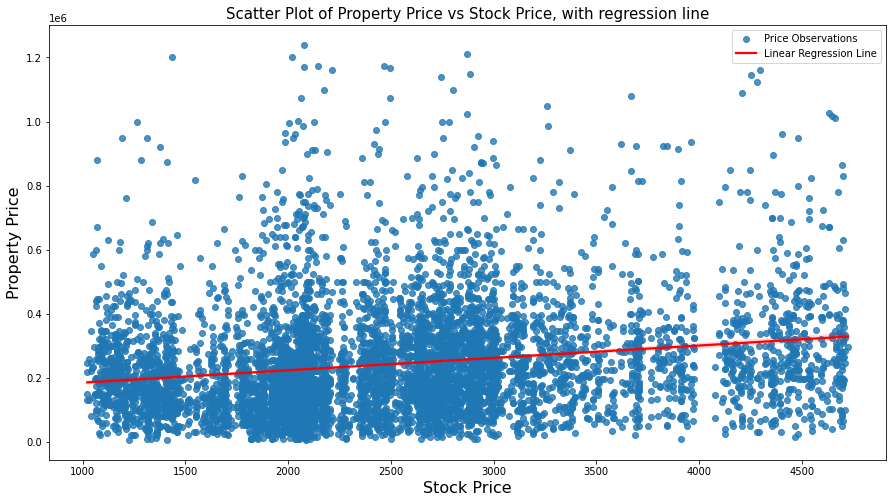

In [27]:
# code for the below inspired from https://stackoverflow.com/questions/29308729/how-to-plot-a-linear-regression-with-datetimes-on-the-x-axis
plt.figure(figsize=(15,8))
ax = sns.regplot(
    x=train['StockPrice'],
    y=train['Price(€)'], line_kws={"color": "red"}
)
plt.ylabel('Property Price', fontsize=16)
plt.xlabel('Stock Price', fontsize=16)
plt.title("Scatter Plot of Property Price vs Stock Price, with regression line", fontsize=15)

plt.legend(labels=["Price Observations","Linear Regression Line"])
plt.show()

As observed and discussed in the correlation matrix above, there is a significantly strong positive relationship between Stock Price and Date. This is indicative of a feature not adding much also to our ability to predict the target, and instead introduce noise. Indeed I note the same general relationship in this chart as seen in the chart plotting Date vs Price, further pointing to the fact that this should not be included. Therefore, I will remove this feature from consideration.

<b>Include in model?</b> No

In [28]:
# do not need this feature any more
train = train.drop(columns=['StockPrice'])
test = test.drop(columns=['StockPrice'])

<b>Population & Price</b>

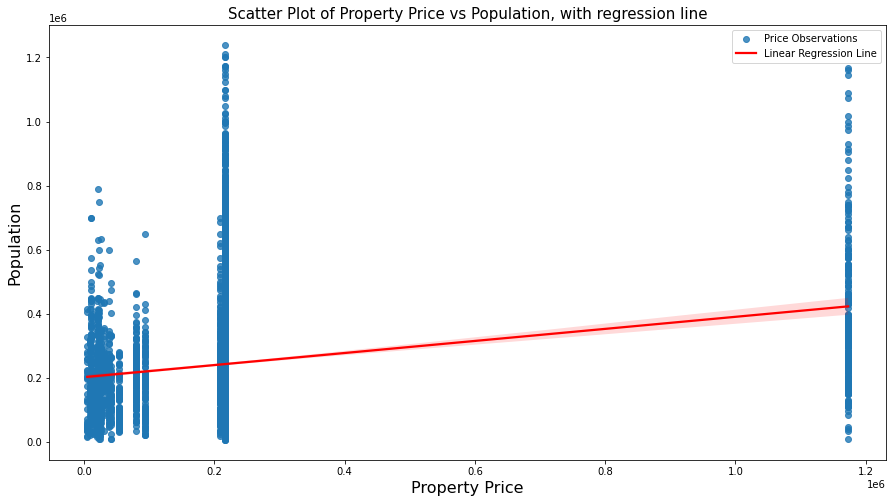

In [29]:
plt.figure(figsize=(15,8))
ax = sns.regplot(
    x=train['Population'],
    y=train['Price(€)'], line_kws={"color": "red"}
)
plt.ylabel('Population', fontsize=16)
plt.xlabel('Property Price', fontsize=16)
plt.title("Scatter Plot of Property Price vs Population, with regression line", fontsize=15)

plt.legend(labels=["Price Observations","Linear Regression Line"])
plt.show()

It appears as though population is behaving like a categorical variable. This is understandable given that there are only a few different population values, applied many times over to different properties located in the same town. In Homework 1 I noted clear positive upward trend between population and mean property price, indicating that the concept of including some aspect relating to the town a property is located in could benefit a model. However, I believe it would be more beneficial to look at Towns as a category, which will be more unique than their population alone would imply. 

<b>Include in model?</b> No

In [30]:
# do not need this feature any more
train = train.drop(columns=['Population'])
test = test.drop(columns=['Population'])

### Categorical Features

<b>County & Price</b>

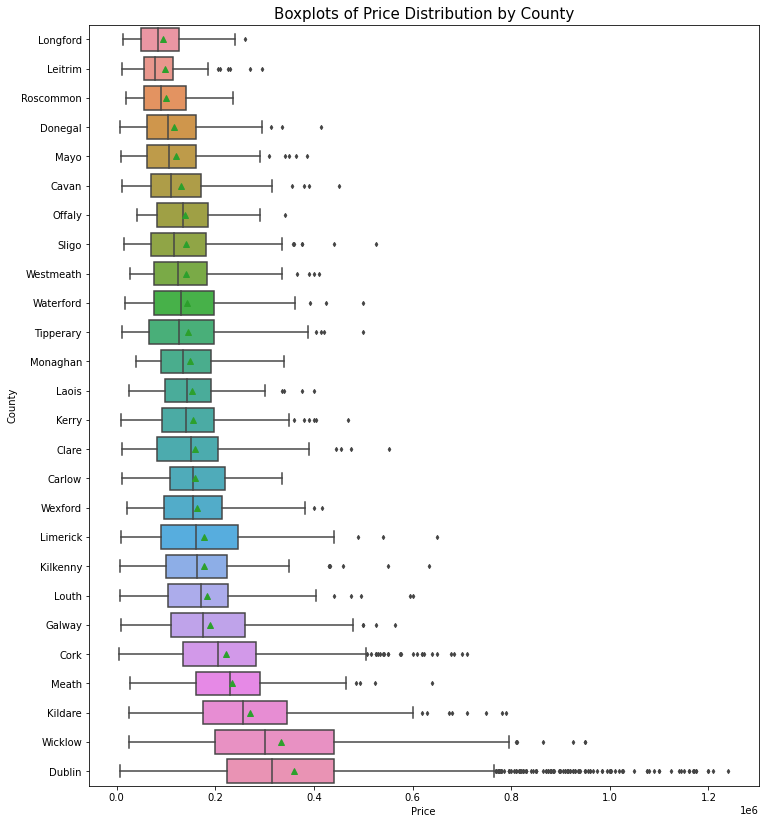

In [31]:
fig, ax = plt.subplots(figsize=(12,14))
means = train['Price(€)'].groupby(train["County"]).mean().sort_values().index
sns.set_context(rc={"font.size":15, "axes.titlesize":15, "axes.labelsize":15})
sns.boxplot(x = train['Price(€)'], y=train['County'], fliersize = 3, showmeans = True, order=means)
plt.xlabel('Price')

plt.title('Boxplots of Price Distribution by County')
plt.show()

From the above it is clear that the county a property is located in has an impact on the price people pay for it.

- Unsurprisingly, the larger counties, as well as those counties close to Dublin show a much higher average over time.
- Dublin has by the largest averages across both mean and median, while Roscommon has the lowest.

With a varied distribution for each county it is clear that the location of a property impacts the price it is sold for, albeit not to a huge degree. It would be worth capturing the unique information the county a property is located in can provide in a model.

<b>Include in model?</b> Yes

<b>Encoding:</b> With 26 categories of counties it is clear that should be captured individually. The categories are clearly not ordinal and are instead nominal. While it would be ideal not to create a significant number of new columns, this will not be a major hindrance to memory and therefore I will use dummy encoding.

In [32]:
countyDummiesTrain = pd.get_dummies(train['County'], prefix='County', drop_first=True)
train = pd.concat([train, countyDummiesTrain], axis=1)

countyDummiesTest = pd.get_dummies(test['County'], prefix='County', drop_first=True)
test = pd.concat([test, countyDummiesTest], axis=1)

train = train.drop(columns=['County'])
test = test.drop(columns=['County'])

<b>Postal Code & Price</b>

In [1]:
fig, ax = plt.subplots(figsize=(12,14))
means = train['Price(€)'].groupby(train["PostalCode"]).mean().sort_values().index
sns.set_context(rc={"font.size":15, "axes.titlesize":15, "axes.labelsize":15})
sns.boxplot(x = train['Price(€)'], y=train['PostalCode'], fliersize = 3, showmeans = True, order=means)
plt.xlabel('Price')
plt.ylabel('Postal Code')
plt.title('Boxplots of Price Distribution by Postal Code')
plt.show()

NameError: name 'plt' is not defined

Similar to the County box plot above, this shows a wide distribution in the price people pay for properties. As this is only available for some properties in Dublin City, it should allow for more robust estimates for properties in these locations. Unfortunately a significant amount of properties will have an 'Unknown' value for this field, however, given the benefits of the increased granularity for predicting properties in Dublin it is worth including this field in the model.

<b>Include in model?</b> Yes

<b>Encoding:</b> For the same reasons provided for the counties above, I will use dummy encoding for the Postal Codes

In [34]:
postalDummiesTrain = pd.get_dummies(train['PostalCode'], prefix='PostalCode', drop_first=True)
train = pd.concat([train, postalDummiesTrain], axis=1)

postalDummiesTest = pd.get_dummies(test['PostalCode'], prefix='PostalCode', drop_first=True)
test = pd.concat([test, postalDummiesTest], axis=1)

train = train.drop(columns=['PostalCode'])
test = test.drop(columns=['PostalCode'])

<b>Town & Price</b>

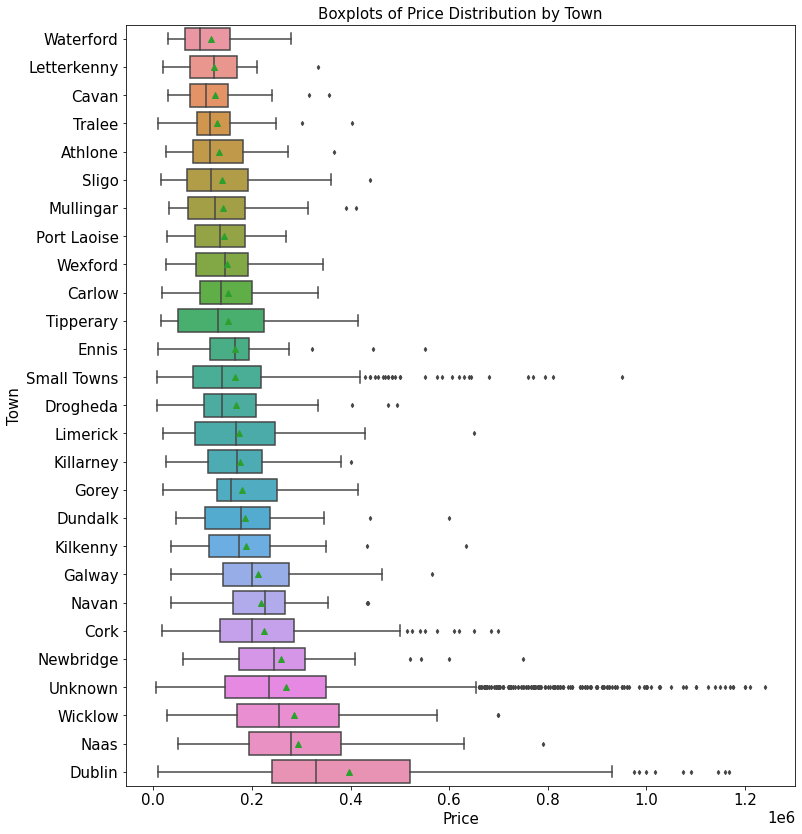

In [35]:
fig, ax = plt.subplots(figsize=(12,14))
means = train['Price(€)'].groupby(train["Town"]).mean().sort_values().index
sns.set_context(rc={"font.size":15, "axes.titlesize":15, "axes.labelsize":15})
sns.boxplot(x = train['Price(€)'], y=train['Town'], fliersize = 3, showmeans = True, order=means)
plt.xlabel('Price')
plt.ylabel('Town')
plt.title('Boxplots of Price Distribution by Town')
plt.show()

A similar story is told in this box plot that is seen above for both the Counties and Postal Codes. However, it is worth commenting on the fact that the greatest differences seen are for Dublin, Naas, Wicklow, Newbridge, Cork and Navan. All of these towns are located in Counties (Dublin, Kildare, Wicklow, Kildare, Cork and Meath, respectively) that show almost identical trends in the box plots for the counties - with the highest prices seen in all of these counties. For this reason, I believe this should not be included in the model, as it would risk overfitting (the information captured by this datapoint would already be captured in County). In addition, as there is a significant quantity of properties that are labelled as Unknown, it would only be a useful feature for a small proportion of properties in any case.

<b>Include in model?</b> No

In [36]:
# do not need this feature any more
train = train.drop(columns=['Town'])
test = test.drop(columns=['Town'])

<b>Property Size Description & Price</b>

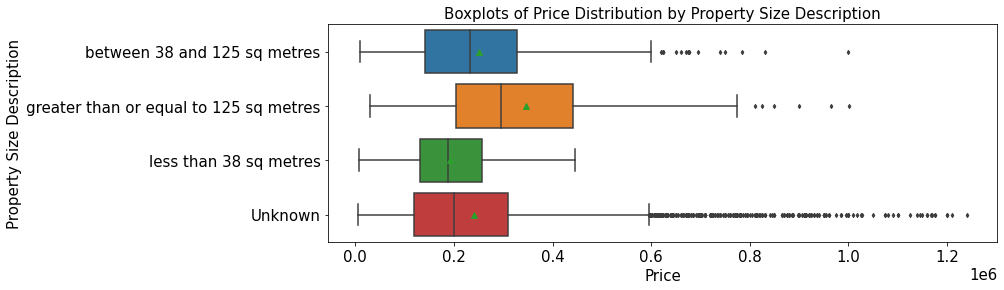

In [37]:
fig, ax = plt.subplots(figsize=(12,4))
sns.boxplot(x = train['Price(€)'], y=train['PropertySizeDescription'], fliersize = 3, showmeans = True)
plt.xlabel('Price')
plt.ylabel('Property Size Description')
plt.title('Boxplots of Price Distribution by Property Size Description')
plt.show()

Indeed, in Homework 1 the PropertySizeDescription feature was observed to be missing entries for over 10% of the properties, and was only used for New Properties. Below I have embedded a chart from Homework 1 that shows the distribution of Properties that have a Property Size Describtion

<img src="Sizes.png">

As the aim here is price prediction in the future, this means we will not receive this piece of information and there is no point including it in our model. Clearly however, were it populated for every new property it would be helpful.

<b>Include in model?</b> No

In [38]:
train = train.drop(columns=['PropertySizeDescription'])
test = test.drop(columns=['PropertySizeDescription'])

<b>Quarter & Price</b>

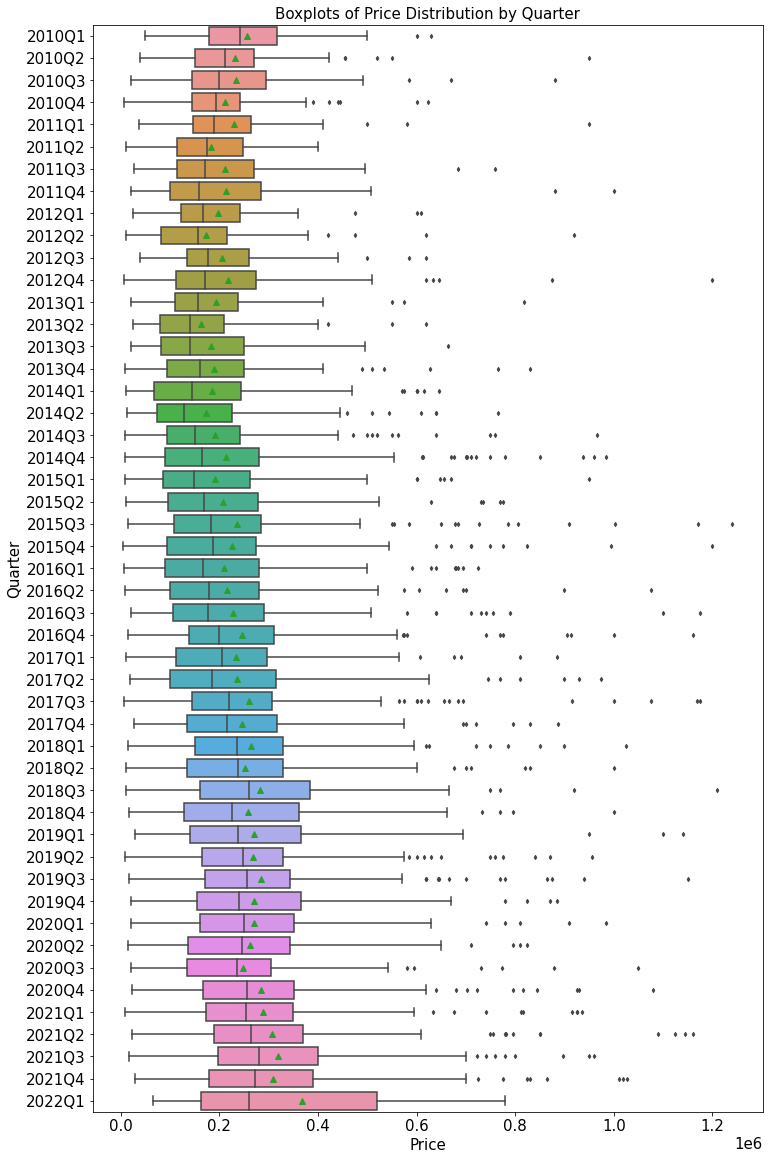

In [39]:
fig, ax = plt.subplots(figsize=(12,20))
sns.boxplot(x = train['Price(€)'], y=(train['quarter']).sort_values(), fliersize = 3, showmeans = True)
plt.xlabel('Price')
plt.ylabel('Quarter')
plt.title('Boxplots of Price Distribution by Quarter')
plt.show()

First recall that I removed the continuous Date of Sale feature, acknowledging that it would be more useful to look at this trend on a categorical basis. House prices are typcially viewed on a quarterly basis when discussing changes in the market. Indeed, looking at this chart there is a more noticeable trend. Generally speaking the price tends to increase as each quarter goes by, albeit with a drop at the beginning of the dataset. It is worth therefore including this in the dataset given the impact timing can have on price.

<b>Include in model?</b> Yes

<b>Encoding:</b> Noting the general trend of the mean price increasing as time increases, and the ordinal nature of this category, I will use ordinal encoding for this feature.

In [40]:
allQuarters = list(set(train['quarter']))
allQuarters.sort()
encoder = LabelEncoder()
encoder.fit(allQuarters)
train['quarter'] = encoder.transform(train['quarter'])
test['quarter'] = encoder.transform(test['quarter'])

<b>Description of Property & Price</b>

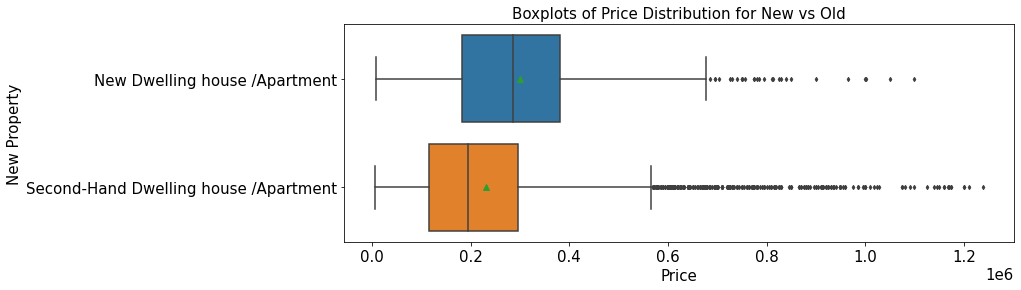

In [41]:
fig, ax = plt.subplots(figsize=(12,4))
sns.boxplot(x = train['Price(€)'], y=train['DescriptionofProperty'], fliersize = 3, showmeans = True)
plt.xlabel('Price')
plt.ylabel('New Property')
plt.title('Boxplots of Price Distribution for New vs Old')
plt.show()

In [42]:
r, p = stats.pearsonr(train['DescriptionofProperty'].map({'New Dwelling house /Apartment':True ,'Second-Hand Dwelling house /Apartment':False}), train['Price(€)'])
print('Pearson\'s correlation r is %s with a p-value = %s' %(round(r,2),round(p,4)))

Pearson's correlation r is 0.15 with a p-value = 0.0


There is a clear noticeable difference in properties that are new and old being sold. New properties are more expensive across all of the metrics (mean, median, and percentiles) shown in the box plot. 

It is also interesting to note the weak positive correlation in price and the property being new. Although small, we can be quite confident in this value given the really small p-value (small probability the relationship occured by chance). It is also interesting to note that this correlation is very similar to those observed for the continuous features.

<b>Include in model?</b> Yes

<b>Encoding:</b> As there is only a binary option between new vs old, I will use one hot encoding, assigning new properties to 1 and second hand to 0.

In [43]:
train['DescriptionofProperty'] = train['DescriptionofProperty'].apply(lambda x: 1 if x == "New Dwelling house /Apartment" else 0)
test['DescriptionofProperty'] = test['DescriptionofProperty'].apply(lambda x: 1 if x == "New Dwelling house /Apartment" else 0)

<b>Final Features</b>

The final features that will be used going forward to predict the target feature 'Price(€)' are therefore 'quarter', 'DescriptionofProperty', 'County' and 'PostalCode', all encoded as described above.

In [44]:
# view df to be used going forward
train.head()

,DescriptionofProperty,Price(€),quarter,County_Cavan,County_Clare,County_Cork,County_Donegal,County_Dublin,County_Galway,County_Kerry,...,PostalCode_Dublin 24,PostalCode_Dublin 3,PostalCode_Dublin 4,PostalCode_Dublin 5,PostalCode_Dublin 6,PostalCode_Dublin 6w,PostalCode_Dublin 7,PostalCode_Dublin 8,PostalCode_Dublin 9,PostalCode_Unknown
0,1,402000.01,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,164000.00,19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,49500.00,23,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,320070.00,34,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,115000.00,13,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Part 2

### 2.1 Training the Linear Model

Following Part 1 I now have 4 encoded features that shall be used to predict the target variable. I will first use these in implementing a linear model.

In [45]:
# set a list of all column names except for Price(€)
predictions = [feature for feature in list(train.columns) if feature != 'Price(€)']
target = 'Price(€)'

In [46]:
# fit the linear model
linreg = LinearRegression().fit(train[predictions], train[target])
linreg_display_df = pd.DataFrame()
linreg_display_df['Feature'] = predictions
linreg_display_df['Coefficient'] = linreg.coef_
intercept = linreg.intercept_
print("Intercept:", intercept)
print("\n Features & their coefficients")
linreg_display_df.sort_values('Coefficient', ascending=False)

Intercept: -42151.179286728

 Features & their coefficients


,Feature,Coefficient
41,PostalCode_Dublin 4,317546.510801
44,PostalCode_Dublin 6w,282733.377066
43,PostalCode_Dublin 6,279439.951395
31,PostalCode_Dublin 14,265373.683130
6,County_Dublin,216078.953006
33,PostalCode_Dublin 16,182254.183883
26,County_Wicklow,180704.133505
35,PostalCode_Dublin 18,163931.551800
40,PostalCode_Dublin 3,147738.321448
9,County_Kildare,113336.654895


### 2.2 Interpreting the Linear Model

<b>Interpretation of Linear Model</b>

Linear regression modelling is a fairly simplistic approach to modelling, one that inherently assumes a linear relationship between each independent variable (in this case 'quarter', 'DescriptionofProperty', 'County' and 'PostalCode') and the dependent variable. Once applied this means that in order to find the prediction for particular inputs we take the intercept and add it to the sum of the products of the independent variables multiplied by the relevant weightings that were found (or so called coefficients). Taken together this results in a model of the form: 

$prediction = intercept + coefficient_1 * feature_1 + coefficient_2 * feature_2 + ...+ coefficient_n * feature_n $

Subbing in known values of the independent variables leads to predicted outcomes for the dependent (i.e. depends on the independent). The coefficients and intercepts are determined based on the training set as a whole, and have been determined as those that will lead to the most accurate predictions (i.e. minimise error) on this specific sample. The above results are very intuitive and I note the following observations.

- The model intercept is -€42,151. This implies that were the values of all other features 0 the price prediction would be negative. Clearly however this is impossible. With a model with as many features as this the probability of all independent variables being 0 is extremely small (and only possible with incomplete data i.e. not actually possible). In practice therefore this means that subbing in values for each of the features alone would lead to a prediction that is estimated to be too high by €42k, and this term will reduce it.
- The DescriptionofProperty coefficient of €49,162 implies that holding all other things constant if a property is new (i.e. the feature value will be 1) the price should be greater by over €49k. This is intuitive as new properties will have a longer life span than second hand ones, or at least are expected to.
- The quarter coefficient of €2,853 essentially means the more recent a property is sold the higher the price will be, increasing by €2,853 every quarter. This imposes the unrealistic outcome of the price consistently rising by the same amount, which we saw at the beginning of the dataset not to be the case. Recalling that 2010Q1 received an encoding of 0, this means that a property sold in this period would not see its prediction rise due to time, but a property sold in 2011Q1 would increase by 4 x €2,853.
- Though quarter is not high in the list it is worth recalling that a value for this feature can be much greater than the maximum of 1 for the others.
- Taking the counties together, first recall that for an individual prediction only one of these coefficients will be relevant. Due to the encoding applied, each county has a column, populated with a 1 if the property is located there and a 0 otherwise. If for example a property is located in Cavan, all other county coefficients will be nullified as the feature values will be 0, and the prediction will decrease by €26,089. If we take Dublin, the prediction will increase by €216,079. Taken together I note the general trend that those counties with a larger population and those that are close to Dublin typically have higher coefficients implying predictions for these locations will be more expensive.
- Taking the Postal Codes finally, the most notable coefficient is that of the 'Unknown' at €104,613. This value will be applied to any property not in Dublin, as well as those in Dublin without a Postal Code. Given that this is the majority of the properties this is almost akin to the effect of an intercept, boosting the prediction of almost all properties. I would expect the reason this happened here and not the intercept itself was due to the high average price (above the Dublin intercept alone) that properties in Dublin without a postal code had. It is interesting to note that those with low postal codes typically have higher coefficients while those with higher odd numbered postal codes are much lower and sometimes negatives. This aligns with the North/Side divide in Dublin, in which we typically see property prices much higher in the South side.


There are some scenarios whereby the linear predictions could be exceptionally poor. For example a second hand property sold in Q1 2010 located in Roscommon would have a predicted price of: $price = -€42,151 + 0 * €49,162 + 0 * €2,853 + 1 * -€48,751 + 1 * €104,613 = €13,7111 $, clearly an unreasonably low price. That being said it will never be possible to find a model (and especially a linear model) that captures the nuance of such a varied dataset and so outcomes like this, while not ideal, are par for the course. 

### 2.3 Evaluating the Model on the Training Set

In [47]:
# get the first 10 rows from the training set
training_10 = train[predictions].head(10)
# use the model to predict values for these rows
predicted10 = linreg.predict(training_10)

In [48]:
# set up a dataframe to show the predictions
print("First 10 predictions with linear regression:")
predicted_df = pd.concat([train['Price(€)'].head(10), pd.DataFrame(predicted10, columns=['Predicted Price'])], axis=1)
predicted_df

First 10 predictions with linear regression:


,Price(€),Predicted Price
0,402000.01,286576.726639
1,164000.00,130595.336411
2,49500.00,201145.796437
3,320070.00,218065.373008
4,115000.00,53270.699591
5,80000.00,179200.244417
6,200000.00,147287.415441
7,130000.00,200330.418091
8,40000.00,151276.876323
9,349999.95,410429.692942


The predictions for the first 10 entries in the training set are a bit of a mixed bag in terms of accuracy, with some close but others quite far from their true value. This is not too surprising for a linear model, and should this be repeated throughout the dataset would lead me to expect a high RMSE.

In [49]:
# use the model to predict values for training set
predictedLinRegTrain = linreg.predict(train[predictions])

In [50]:
# used to compute all metrics
def RegressionMetrics(actualVal, predictions, num_pred, num_samples):
    # classification evaluation measures
    print("MAE:", metrics.mean_absolute_error(actualVal, predictions))
    print("RMSE:", metrics.mean_squared_error(actualVal, predictions)**0.5)
    r2 = metrics.r2_score(actualVal, predictions)
    print("R2:", r2)
    print("Adjusted R2:", 1 - ((1-r2) * ((num_samples-1)/(num_samples-num_pred-1))))

In [51]:
samples = train.shape[0]
predictors = train[predictions].shape[1]
print("\u0332".join("Regression Evaluation Measures for Training Set"))
RegressionMetrics(train[target], predictedLinRegTrain, predictors, samples)

R̲e̲g̲r̲e̲s̲s̲i̲o̲n̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲a̲s̲u̲r̲e̲s̲ ̲f̲o̲r̲ ̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲S̲e̲t
MAE: 92917.85232605808
RMSE: 131895.32776875637
R2: 0.4140152003263714
Adjusted R2: 0.40960185031345897


<b>Discussion of Results</b>

- <b>MAE:</b> In simple terms the mean absolute error term is the average of all of the errors experienced by the model. This means that on average we can expect the model to be off for any particular estimate, above or below the actual Price, by €92,918. This is an exceptionally high number and given the distribution of the house prices in our model, indicative of somewhat of a poor model.
- <b>RMSE:</b> Unlike the MAE which simply takes the raw absolute difference between actual and predicted, RMSE takes the square of this difference, before taking the square root of the average of these. This means that the measure is senstive to outliers, since a single large outlier will have a greater impact on the total than many small values dispersed around the mean. As the RMSE is quite large here at €131,895, it means that making up the set of error terms are quite a few large errors, as these have been punished in this figure. This is undesirable and as the RMSE is high points to the fact that we have a relatively poor model.
- <b>R<sup>2</sup>:</b> Commonly termed the coefficient of determination, R<sup>2</sup> essentially tells us how much of the variation in x (our independent variables) explain the variation observed in y (our dependent variable, or Price in this instance). It tells us how well therefore a model fits the dataset. In this case we can say that 41% of the variation of our target feature can be explained by our independent variables. Thus the rest is explained by features not caught in our model, implying we do not have a great model.
- <b>Adjusted R<sup>2</sup>:</b> A drawback of R<sup>2</sup> is that adding more independent variables (of which I have a lot), artificially increases it. Adjusted R<sup>2</sup> will always be lower than R<sup>2</sup>, but a sign that the model has not been overfit is when both are close. In this instance both are close meaning we have a reliable R<sup>2</sup> value.

In conclusion based on the above metrics it looks as though Linear Regression did not produce great predictions.

### 2.4 In Depth Model Evaluation on the Test Set

In [52]:
predictedTest = linreg.predict(test[predictions])

In [53]:
print("\u0332".join("Regression Evaluation Measures for Test Set"))
RegressionMetrics(test[target], predictedTest, predictors, test.shape[0])

R̲e̲g̲r̲e̲s̲s̲i̲o̲n̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲a̲s̲u̲r̲e̲s̲ ̲f̲o̲r̲ ̲T̲e̲s̲t̲ ̲S̲e̲t
MAE: 93517.65497917107
RMSE: 130642.8708647698
R2: 0.3928722106657734
Adjusted R2: 0.38209349266672366


<b>Discussion of Test Results</b>

Despite the fact that we observed somewhat poor results on the training set it is good to see that the model is generalising on data it has not seen before. All metrics are quite similar to what they were on the training data, indicative of a model that was not overfit. Indeed it is likely just the case that the linear relationships imposed through this model are not sufficient enough to predict house prices.

Next I will perform cross validation on the entire (train and test combined) dataset. I will then split this dataset into 10 folds. The reason for this is to rule out that the above train/test split results occured due to random chance, and to see what the expected test error is when we conduct the same modelling on different splits of the data. Splitting the dataset into 10 equal folds will mean the same train/test split conducted above will be carried out 10 times, each fold being used as a training set once, and the remaining 9 folds then used as a test set. The average error terms should be close to the true values for a linear model on this dataset using my chosen features.

In [54]:
# setting list of metrics to report for the cross validation
testMetrics = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

# merging entire dataset
entire_dataset = pd.concat([train, test]).reset_index(drop=True)

# conducting cross validation
kfold = cross_validate(LinearRegression(), entire_dataset[predictions], entire_dataset[target], scoring=testMetrics, cv=10)

In [55]:
# below function from https://stackoverflow.com/questions/51938245/display-dataframe-values-in-bold-font-in-one-row-only
def highlight_last(x):
    return ['font-weight: bold' if v == x.iloc[-1] else '' for v in x]

In [56]:
df_cross_validate = pd.DataFrame()
df_cross_validate['Fold'] = [x for x in range(1,11)]
df_cross_validate['MAE'] = -kfold['test_neg_mean_absolute_error']
df_cross_validate['RMSE'] = -kfold['test_neg_mean_squared_error']
df_cross_validate['RMSE'] = df_cross_validate['RMSE'].apply(lambda val: math.sqrt(val))
df_cross_validate['R2'] = kfold['test_r2']

ave_row_lin_reg = {'Fold':'Average', 'MAE':df_cross_validate['MAE'].mean(), 'RMSE':df_cross_validate['RMSE'].mean(),
           'R2':df_cross_validate['R2'].mean()}

df_cross_validate = df_cross_validate.append(ave_row_lin_reg, ignore_index=True)
df_cross_validate =df_cross_validate.style.apply(highlight_last)

df_cross_validate

,Fold,MAE,RMSE,R2
0,1,93489.201947,129341.129420,0.394187
1,2,92675.388123,136757.234819,0.389918
2,3,95985.182702,137240.555086,0.387014
3,4,93108.577378,131278.731801,0.412832
4,5,96650.318943,134700.944884,0.413083
5,6,92159.371056,132154.117547,0.424016
6,7,91862.174967,127523.969484,0.422318
7,8,93471.710201,136603.771489,0.384315
8,9,96343.472001,135785.118001,0.379621
9,10,90684.833404,118642.959708,0.420431


<b>Discussion of Cross Validation Results</b>

Above I have displayed the MAE, RMSE and R<sup>2</sup> values for each of the folds, which are generally stable and do not show considerable variation. Noticeably, these are all very similar to the results of the original train/test split, meaning that the results of out-of-sample data is stable, and we can be relatively confident in how accurate the linear model is (albeit a low level of accuracy). It would be interesting to conduct similar splits, using test data in the future (i.e. for ranges of dates the training set did not see) to observe how this type of out-of-sample data is handled in terms of prediction error.

With high MAEs and RMSEs, and low R<sup>2</sup>, there is significant scope for model improvement. The high RMSE in particular implies that there are quite a few instances of predictions being very far from their true value, implying that there is a feature(s) not being captured correctly in the linear model.

## Part 3

### 3.1 Training the Decision Tree Models & Setting Up Price Quantiles

In the next two sections I will use the same features as before to predict property prices, this time treating Price as a categorical variable in classification, as well as a continuous variable in regression. The aim here of the classification model is to classify prices into their appropriate class, or range, instead of actually predicting a price. This is more intuitive. Instead of for example predicting that a property should be sold for €351,578.67 for example, it would make more sense to say we expect it to be sold for a price in the range €330,000-€360,000. This clearly allows for more accurate estimates as it is more likely that you can predict the range than an exact price. 

Below I have split the prices into quantiles, each containing 10% of the distribution of prices in the training set. I also added a value of 0 and infinity to the range, to ensure that when the same quantiles were applied to other datasets, if the minimum and/or maximum is less/greater than that of the training set they will still be categorised as appropriate.

<b>Discussion of models used</b>

Both a Decision Tree Classifier and Decision Tree Regressor were used for this section. Decision trees can be viewed as a learned series of answers to various questions posed. The answers to a question bring you down different branches depending, and once a leaf is reached based on the answers from a specific set of inputs the learned output is the prediction. The decision to split at a certain node is based on information gain (known as the Gini Index), and will split at the point that has the highest Gini Index. For a specific example relating to this dataset, if the question was based on the 'DescriptionofProperty' column, a 1 (i.e. new property) would bring us down 1 branch while a 0 would bring us down another. With a Decision Tree Classifier model, the 'answers' in the leaves are classes that the target feature can belong to. In this section I have split the prices into 10 different classes, aiming to correctly classify a house price based on its specific features. I have also implemented a Decision Tree Regressor model here. There may be more variability in the predictions for these but it will lead to much more straightforward comparisons against the linear regression model.

In [57]:
#quantiles = train['Price(€)'].quantile([.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]).tolist()
quantiles = train['Price(€)'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]).tolist()
quantiles = [0] + quantiles + [float('inf')]
quantiles
quartile_df = pd.DataFrame({'Quantile': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], 'Upper Price Range':quantiles[1:]})
print("\u0332".join("Price quantiles to be used for classification"))
quartile_df

P̲r̲i̲c̲e̲ ̲q̲u̲a̲n̲t̲i̲l̲e̲s̲ ̲t̲o̲ ̲b̲e̲ ̲u̲s̲e̲d̲ ̲f̲o̲r̲ ̲c̲l̲a̲s̲s̲i̲f̲i̲c̲a̲t̲i̲o̲n


,Quantile,Upper Price Range
0,0.1,68000.0
1,0.2,104000.0
2,0.3,140000.0
3,0.4,173000.0
4,0.5,206000.0
5,0.6,247000.0
6,0.7,287327.5
7,0.8,345000.0
8,0.9,450000.0
9,1.0,inf


Above is the list of quantiles that will be used to classify each price. The Upper Price Range column specifies the maximum price a property can have to be in that quartile. As the final quartile includes infinity, it will be possible for any price to be assigned an approprite classification.

In [58]:
train['quantiles'] = pd.cut(train['Price(€)'], bins=quantiles, labels=["0.1","0.2","0.3","0.4","0.5","0.6","0.7","0.8","0.9","1"] )
test['quantiles'] = pd.cut(test['Price(€)'], bins=quantiles, labels=["0.1","0.2","0.3","0.4","0.5","0.6","0.7","0.8","0.9","1"] )
test.sort_values("Price(€)")

,DescriptionofProperty,Price(€),quarter,County_Cavan,County_Clare,County_Cork,County_Donegal,County_Dublin,County_Galway,County_Kerry,...,PostalCode_Dublin 3,PostalCode_Dublin 4,PostalCode_Dublin 5,PostalCode_Dublin 6,PostalCode_Dublin 6w,PostalCode_Dublin 7,PostalCode_Dublin 8,PostalCode_Dublin 9,PostalCode_Unknown,quantiles
774,0,6847.31,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.1
2755,0,8250.00,24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.1
2707,1,9080.00,15,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.1
99,1,9080.00,15,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.1
1633,1,9080.00,15,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,0,1110000.00,2,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
776,0,1131000.00,32,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
1357,0,1200000.00,46,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
450,0,1200000.00,22,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1


Above each row has been assigned a price classification based on its value in the Price column. I have sorted the test dataframe, to which the quantiles defined using the train dataframe have been applied, by Price, to show how this classification works. We can see that the lower prices have all been categorised as '0.1', indicating they are below the 10th percentile, or below a price of €68,000. Similarly, the higher prices have been categorised as '1.0', meaning they are in the top 10th percentile, or above a price of €450,000. Clearly we can see this makes the dataset considerably less variable.

In [59]:
# make quartiles column a category so that the Decision Tree Classifier and Random Forest Models can
# use the 10 quartile categories
train['quantiles'] = train['quantiles'].astype('category')

A big decision when training a model such as this is the maximum depth. Increasing the maximum depth allowed by the model increases the complexity and specifity of the model. You could technically represent the features of every single property in the training set with a tree thats large enough, to lead to very good accuracy. However, once you generalised the model to another dataset - varying the features only slightly would then lead to poor results.

It is therefore important to choose a maximum depth that strikes an appropriate balance between the specificity required to capture the problem set sufficiently, while at the same time not overfitting. Evidence of overfitting would be good evaluation measures for the training set that the model was built on and significantly worse measures for any out of sample set.

I have therefore set a max depth of 10 for both the regression and classification decision tree models.

In [60]:
# initialise the DecisionTreeClassifier
# set random state value so that results can be replicated
decTreeClass = DecisionTreeClassifier(max_depth=10, random_state=1)

# fit the model on the training set using the predictions features
# y value is now the quantiles
decTreeClass.fit(train[predictions], train['quantiles'])

DecisionTreeClassifier(max_depth=10, random_state=1)

In [61]:
# initialise the DecisionTreeRegressor
# set random state value so that results can be replicated
decTreeReg = DecisionTreeRegressor(max_depth=10, random_state=1)

# fit the model on the training set using the predictions features
# y value is price for regression
decTreeReg.fit(train[predictions], train[target])

DecisionTreeRegressor(max_depth=10, random_state=1)

### 3.2 Interpreting the Decision Tree Models

In [62]:
with open("PropPricesClass.dot", 'w') as f:
    f = export_graphviz(decTreeClass, out_file=f, feature_names=train[predictions].columns)

path = './PropPricesClass.dot'
s = Source.from_file(path)
s.view()

'PropPricesClass.dot.pdf'

<img src="PropPricesClass.png">

In [63]:
print("Number of nodes in the Decision Tree Classifier:", decTreeClass.tree_.node_count)

Number of nodes in the Decision Tree Classifier: 665


In [64]:
with open("PropPricesReg.dot", 'w') as f:
    f = export_graphviz(decTreeReg, out_file=f, feature_names=train[predictions].columns)

path = './PropPricesReg.dot'
s = Source.from_file(path)
s.view()

'PropPricesReg.dot.pdf'

<img src="PropPricesReg.png">

In [65]:
print("Number of nodes in the Decision Tree Regressor:", decTreeReg.tree_.node_count)

Number of nodes in the Decision Tree Regressor: 701


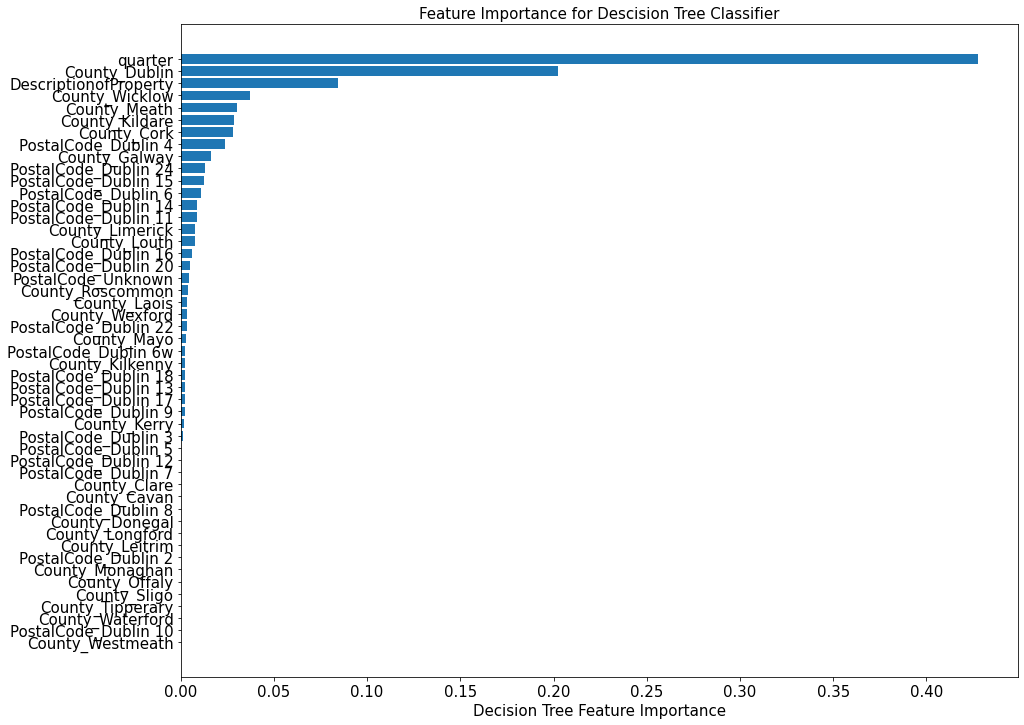

In [66]:
sorted_idx = decTreeClass.feature_importances_.argsort()
plt.figure(figsize=(15,12))
plt.barh(train[predictions].columns[sorted_idx], decTreeClass.feature_importances_[sorted_idx])
plt.xlabel("Decision Tree Feature Importance")
plt.title("Feature Importance for Descision Tree Classifier")
plt.show()

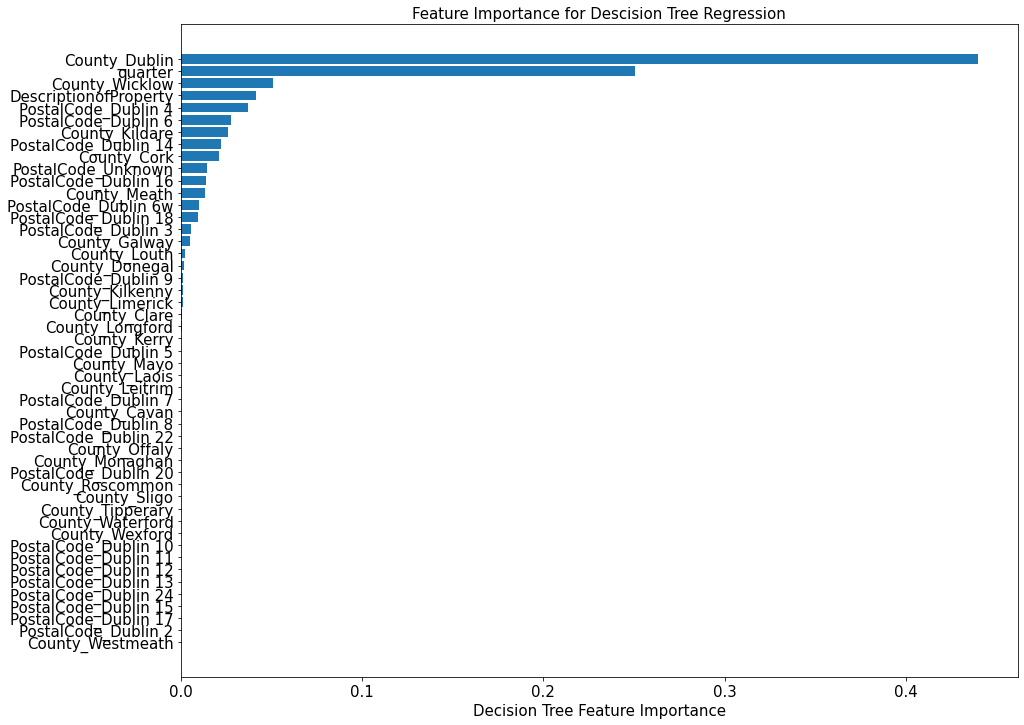

In [67]:
sorted_idx = decTreeReg.feature_importances_.argsort()
plt.figure(figsize=(15,12))
plt.barh(train[predictions].columns[sorted_idx], decTreeReg.feature_importances_[sorted_idx])
plt.xlabel("Decision Tree Feature Importance")
plt.title("Feature Importance for Descision Tree Regression")
plt.show()

<b>Interpretation of Decision Tree Models</b>

As mentioned above, there is an important trade off concerning the maximum depth chosen for a decision tree. The depth determines how many 'questions' can be asked by the tree before an answer (i.e. prediction) must be reached. Choose too high and the tree will be far too specific to the training set and lack the generality for accurate predictions on new datasets. Too low and it will not capture the characteristics of all features in the model, also leading to inaccurate predictions. Below I analyse both Decision Trees, and focus on the impact the max depth chosen had. It is worth noting first however that through testing various maximum depths I observed that it was at 10 levels that the difference between the in and out of sample evaluation measures were minimised. An important trait of a good decision tree model is one that does not have large differences in this regard, as it is a sign the model was overfit.

<u>Decision Tree Classifier</u><br>
One of the most notable drawbacks of the decision to only have 10 levels is that we can see in the above chart that not all of the features were incorporated. The reason for this is quite simple - the features that were ignored simply do not play an important enough role in determining the price of the property. Looking at the graph itself we can see the most important feature was quarter, implying that a key determinant of the price will be the time it was sold, aligning with the observation earlier that prices rise over time. In the chart we can see this accounts for over 50% of the variability, which is quite high. I also note that the property being in Dublin plays a huge role in determining its price, again intuitive in that the most expensive (and most differently priced) properties were in the capital. The first split (the root node) was Dublin being above or below 0.5 (i.e. being in or out of Dublin), which would lead to the expectation that properties that are in Dublin will receive higher price predictions in general. The property being new or old, as well as belonging to some other expensive Counties and Postal Codes all were important features, while some of the smaller counties and postal codes were left out completely, likely due to the fact that not many properties were located in these areas. It is unfortunate that such a small number of factors were seen to completely dominate the prediction.


<u>Decision Tree Regressor</u><br>
A similar but varied story is told by the Decision Tree Regressor model. Once again being in Dublin and the quarter sold account for the two most important determinants of the price, accounting for almost 70% of the variability combined. Belonging to Dublin is once again the root node being the first 'question' asked by the tree. It is notable to observe that it is the same features once again that seem to determine the price prediction as seen in the Classifier model. This implies the strong prevalance of these in the data (which was confirmed in Homework 1) as well as the strong impact they have on price variability (e.g. in both models being new or old leads to varied price predictions). Indeed the same set of features also look not to be included in the model, such as some of the smaller counties and postal codes. These would have been noted to impact the property prices to a very small given that they were likely closer to the mean and there were few in each category. Given that it is such few features that determine the prediction, I would not be surprised to see poor measures of evaluation, particularly the likes of RMSE which will inflate due to the presence of outliers.

### 3.3 Evaluating the Model on the Training Set

In [68]:
decTreeClassPredictedTrain10 = decTreeClass.predict(train[predictions].head(10))
print("First 10 predictions with Decision Tree Classification:")
predicted_df_train_class = pd.concat([train['quantiles'].head(10), pd.DataFrame(decTreeClassPredictedTrain10, columns=['Predicted Price Quantile'])], axis=1)
predicted_df_train_class

First 10 predictions with Decision Tree Classification:


,quantiles,Predicted Price Quantile
0,0.9,0.8
1,0.4,0.3
2,0.1,0.3
3,0.8,0.6
4,0.3,0.1
5,0.2,0.2
6,0.5,0.1
7,0.3,0.5
8,0.1,0.2
9,0.9,0.9


In [69]:
decTreeRegPredictedTrain10 = decTreeReg.predict(train[predictions].head(10))
print("First 10 predictions with Decision Tree Regression:")
predicted_df_train_reg = pd.concat([train[target].head(10), pd.DataFrame(decTreeRegPredictedTrain10, columns=['Predicted Price'])], axis=1)
predicted_df_train_reg

First 10 predictions with Decision Tree Regression:


,Price(€),Predicted Price
0,402000.01,312499.040000
1,164000.00,106169.773569
2,49500.00,160525.963455
3,320070.00,216034.161636
4,115000.00,106169.773569
5,80000.00,148298.646052
6,200000.00,106169.773569
7,130000.00,182328.528372
8,40000.00,148298.646052
9,349999.95,434140.871230


Looking at the sample of predictions above for both models, we can see generally a mixed bag in terms of accuracy. The Classification model is rarely correct but usually very close to the actual answer, while the Regression model is also generally close. It is interesting to observe that some of the predicted prices for the Regression model are the exact same numbers, unsurprising due to the nature of the 10 layers of questions that are followed for each property. Ultimately it would imply that the properties with the same prediction followed the same tree path.

In [70]:
# predict entire training dataset using decision tree class model
decTreeClassPredictedTrain = decTreeClass.predict(train[predictions])

In [71]:
# predict entire training dataset using decision tree regressor model
decTreeRegPredictedTrain = decTreeReg.predict(train[predictions])

In [72]:
# https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd
print("Confusion matrix: \n", metrics.confusion_matrix(train['quantiles'], decTreeClassPredictedTrain))
print("\u0332".join("\nClassification Report for Training Set"))
print(classification_report(train['quantiles'], decTreeClassPredictedTrain))

Confusion matrix: 
 [[328 148  86   8  34  29  13   2   2   7]
 [246 191  84  10  45  52  13   7   2   5]
 [192 130 157  14  47  90  15   5   5  13]
 [119 145  90  74  54 109  18   7  12  22]
 [ 89 108  77  24 137 123  21  11  21  42]
 [ 55  80  59  22  76 242  26  14  27  57]
 [ 44  53  57  19  68 154  93  29  42  89]
 [ 29  54  47  16  51 130  19 108  62 143]
 [ 16  34  29  14  44 104  14  34 199 171]
 [ 12  13  12   6  24  87  17  13  83 382]]

̲C̲l̲a̲s̲s̲i̲f̲i̲c̲a̲t̲i̲o̲n̲ ̲R̲e̲p̲o̲r̲t̲ ̲f̲o̲r̲ ̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲S̲e̲t
              precision    recall  f1-score   support

         0.1       0.29      0.50      0.37       657
         0.2       0.20      0.29      0.24       655
         0.3       0.22      0.24      0.23       668
         0.4       0.36      0.11      0.17       650
         0.5       0.24      0.21      0.22       653
         0.6       0.22      0.37      0.27       658
         0.7       0.37      0.14      0.21       648
         0.8       0.47      0.16     

In [73]:
print("\u0332".join("Regression Evaluation Measures for Training Set"))
RegressionMetrics(train[target], decTreeRegPredictedTrain, predictors, train.shape[0])

R̲e̲g̲r̲e̲s̲s̲i̲o̲n̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲a̲s̲u̲r̲e̲s̲ ̲f̲o̲r̲ ̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲S̲e̲t
MAE: 85788.33020656905
RMSE: 122072.52286196474
R2: 0.4980466371981501
Adjusted R2: 0.49426617073991297


<u>Decision Tree Classifier</u><br>
- The <b>confusion matrix</b> shows a significant number of incorrect predictions for the training set, with the model in every case predicting a few properties in each of the incorrect quantiles. Generally however, there is a concentration along the diagonal as one would hope for, along with a significant number of predictions falling either side of the diagonal.
- <b>Accuracy</b> of 0.29 implies the model correcty predicted the quantile 29% of the time. This seems quite poor.
- As the <b>precision</b> scores are higher for the upper quantiles this implies that when the model predicts a price to be in a higher quantile it is more likely to truly be there than when it predicts it to be in a lower quartile.
- The <b>recall</b> scores look to be highest for the upper and lower quantiles. This implies that if a price is truly in an upper or lower quartile the model is more likely to predict these correctly.
- <b>F1</b> scores are quite poor and are a combination of the precision and recall.
- Overall the scores are okay but would hint at room for improvement.

<u>Decision Tree Regressor</u><br>
- <b>MAE:</b> is sligtly lower than that of the linear regression model for the training set (€86k vs €93k). This implies there are less errors overall in this model.
- <b>RMSE:</b> Also lower than the linear regression model (€122k vs €132k). Again this implies lower errors in this model, in particular the prevalence of larger errors (outliers) which are amplified in this model.
- <b>R<sup>2</sup>:</b> Better than that of the linear regression model (0.50 vs 0.41), telling us that more of the variation in the actual value is being captured by the variation in the independent variables.
- Overall this hints at a better model than that of the linear regression model but we will need to see how it generalises.

### 3.4 In Depth Model Evaluation on the Test Set

In [74]:
decTreeClassPredictedTest = decTreeClass.predict(test[predictions])
print("Confusion matrix: \n", metrics.confusion_matrix(test['quantiles'], decTreeClassPredictedTest))
print("\u0332".join("\nClassification Report for Test Set"))
print(classification_report(test['quantiles'], decTreeClassPredictedTest))

Confusion matrix: 
 [[153  54  37   2  14  15   6   1   3   0]
 [108  63  43   5  20  36   4   3   3   1]
 [ 99  45  46   9  25  30  10   4   4   6]
 [ 60  68  36  15  31  56  10   3   5  10]
 [ 37  47  33   4  37  54  16   4   5  27]
 [ 30  46  22   8  34  56  18   7  13  31]
 [ 27  38  26   8  22  68  15  12  29  37]
 [ 12  20  11   6  31  46  16  30  34  62]
 [  8  20  16   4  25  47   6  18  67  88]
 [  4   7   7   3  18  43   8  13  47 139]]

̲C̲l̲a̲s̲s̲i̲f̲i̲c̲a̲t̲i̲o̲n̲ ̲R̲e̲p̲o̲r̲t̲ ̲f̲o̲r̲ ̲T̲e̲s̲t̲ ̲S̲e̲t
              precision    recall  f1-score   support

         0.1       0.28      0.54      0.37       285
         0.2       0.15      0.22      0.18       286
         0.3       0.17      0.17      0.17       278
         0.4       0.23      0.05      0.08       294
         0.5       0.14      0.14      0.14       264
         0.6       0.12      0.21      0.16       265
         0.7       0.14      0.05      0.08       282
         0.8       0.32      0.11      0.17   

In [75]:
# predict entire test dataset using decision tree regressor model
decTreeRegPredictedTest = decTreeReg.predict(test[predictions])
print("\u0332".join("Regression Evaluation Measures for Test Set"))
RegressionMetrics(test[target], decTreeRegPredictedTest, predictors, test.shape[0])

R̲e̲g̲r̲e̲s̲s̲i̲o̲n̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲a̲s̲u̲r̲e̲s̲ ̲f̲o̲r̲ ̲T̲e̲s̲t̲ ̲S̲e̲t
MAE: 95761.11094504964
RMSE: 134924.1962280216
R2: 0.3524275559674128
Adjusted R2: 0.34093079880886323


Testing the models produced earlier on the test set indicates how well our models generalise to unseen data. The risk with decision tree models in particular lies in setting the depth too high, which would lead to a model that is very accurate for the specific (i.e. what it was trained on) but worse for the general.

<i>As mentioned previously, it is worth noting that when choosing the maximum tree depth I factored in the differences between the out of sample and in sample evaluation measures, and tried to choose a value that minimised these.</i>

<u>Decision Tree Classifier</u><br>
- The <b>confusion matrix</b> looks to be in worse shape than what we saw for the training set. Although there is still a concentration down the diagonal the results are definitely more dispersed around the indexes on the diagonal, indicating that there were a lot more predictions close to correct but not quite.
- <b>Accuracy</b> of 0.22 implies the model correcty predicted the quantile 22% of the time. This is lower than the 29% seen in the training set, and only 12% higher than what you would expect if you were to randomly guess the quantile.
- The <b>precision</b> scores show the same trend in being higher for the upper quantiles. They are generally lower however, indicating that when the model predicts a price to be in a specific quantile it is less likely to truly be there.
- The <b>recall</b> scores are generally poorer across the board, indicating that the model is less likely to predict that a price is in a specific quantile if it is actually there.
- <b>F1</b> scores are again quite poor and are a combination of the precision and recall.
- Overall the scores are much worse than what we saw for the trained dataset, indicating that the generalisation of the model is not super.

<u>Decision Tree Regressor</u><br>
- <b>MAE:</b> is much higher than that of the training MAE (€96k vs €86k). Indeed it is also higher than the MAE for the linear regression model for the test set, which showed little variation between the train and test. This implies that this model is more specific to the training set.
- <b>RMSE:</b> Also much higher than the training RMSE (€134k vs €122k) showing there is a greater presence of errors and outliers when applied to the test set. 
- <b>R<sup>2</sup>:</b> Now worse than the equivalent R<sup>2</sup> for the linear regression model.
- Overall the model showed a relatively poor ability to generalise to this unseen dataset. The differences in the evaluation measures between the train and test for the linear regression model were much lower than what we saw here.

In [76]:
# remake entire dataset now that the price quantiles have been added
entire_dataset2 = pd.concat([train, test]).reset_index(drop=True)

In [77]:
kfoldTreeClass = cross_val_score(DecisionTreeClassifier(max_depth=None, random_state=1), 
                       entire_dataset2[predictions], entire_dataset2['quantiles'],scoring='accuracy', cv=10)

In [78]:
print("\u0332".join("\nModel Accuracy for cross validation of Descision Tree Classifier: 10 Folds"))
tree_class_df = pd.DataFrame()
tree_class_df['Fold'] = [x for x in range(1,11)]
tree_class_df['Model Accuracy'] = kfoldTreeClass
ave_row_tree_class = {'Fold':'Average', 'Model Accuracy':tree_class_df['Model Accuracy'].mean()}
tree_class_df = tree_class_df.append(ave_row_tree_class, ignore_index=True)
tree_class_df =tree_class_df.style.apply(highlight_last)
tree_class_df



̲M̲o̲d̲e̲l̲ ̲A̲c̲c̲u̲r̲a̲c̲y̲ ̲f̲o̲r̲ ̲c̲r̲o̲s̲s̲ ̲v̲a̲l̲i̲d̲a̲t̲i̲o̲n̲ ̲o̲f̲ ̲D̲e̲s̲c̲i̲s̲i̲o̲n̲ ̲T̲r̲e̲e̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r̲:̲ ̲1̲0̲ ̲F̲o̲l̲d̲s


,Fold,Model Accuracy
0,1,0.186766
1,2,0.218783
2,3,0.210245
3,4,0.203842
4,5,0.205977
5,6,0.200640
6,7,0.195513
7,8,0.191239
8,9,0.191239
9,10,0.222222


In [79]:
# conducting cross validation
kfoldTreeReg = cross_validate(DecisionTreeRegressor(max_depth=10, random_state=1), entire_dataset2[predictions], entire_dataset2[target], scoring=testMetrics, cv=10)

In [80]:
print("\u0332".join("\nRegression Evaluation Measures for cross validation of Descision Tree Regressor: 10 Folds"))
df_cross_validate = pd.DataFrame()
df_cross_validate['Fold'] = [x for x in range(1,11)]
df_cross_validate['MAE'] = -kfoldTreeReg['test_neg_mean_absolute_error']
df_cross_validate['RMSE'] = -kfoldTreeReg['test_neg_mean_squared_error']
df_cross_validate['RMSE'] = df_cross_validate['RMSE'].apply(lambda val: math.sqrt(val))
df_cross_validate['R2'] = kfoldTreeReg['test_r2']

ave_row_tree_reg = {'Fold':'Average', 'MAE':df_cross_validate['MAE'].mean(), 'RMSE':df_cross_validate['RMSE'].mean(),
           'R2':df_cross_validate['R2'].mean()}

df_cross_validate = df_cross_validate.append(ave_row_tree_reg, ignore_index=True)
df_cross_validate =df_cross_validate.style.apply(highlight_last)

df_cross_validate


̲R̲e̲g̲r̲e̲s̲s̲i̲o̲n̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲a̲s̲u̲r̲e̲s̲ ̲f̲o̲r̲ ̲c̲r̲o̲s̲s̲ ̲v̲a̲l̲i̲d̲a̲t̲i̲o̲n̲ ̲o̲f̲ ̲D̲e̲s̲c̲i̲s̲i̲o̲n̲ ̲T̲r̲e̲e̲ ̲R̲e̲g̲r̲e̲s̲s̲o̲r̲:̲ ̲1̲0̲ ̲F̲o̲l̲d̲s


,Fold,MAE,RMSE,R2
0,1,95192.108338,134199.931934,0.347816
1,2,95245.098987,141349.808315,0.348255
2,3,97318.072187,143536.534055,0.329482
3,4,98002.073216,140153.793074,0.330758
4,5,97309.032838,136567.464513,0.396705
5,6,94871.882608,136720.945728,0.383519
6,7,94863.915229,131776.680047,0.383146
7,8,94966.671714,138401.339351,0.368004
8,9,97636.235250,139668.837892,0.343625
9,10,95967.189094,131738.956434,0.285422


<b>Discussion of Cross Validation Results</b>

Generally speaking there is little evidence to suggest that the evaluation measures seen for each model applied to the test sets were inaccurate. The accuracy scores for the Decision Tree Classifier are generally stable at around about 0.2, indicating that our model will only be correct for unseen data 20% of the time, only double that of what we would expect for a guess. Meanwhile the MAE, RMSE and R<sup>2</sup> are all close to the regression evaluation measures above, and indeed all are quite poor compared to the linear regression model.

Overall it was disappointing to see significantly better performance in the training dataset than the test. This implies that the models are poor at generalising and indicate that it may be overfit (I note here once more that the maximum depth was chosen so as to minimise the difference in evaluation measures) for certain reasons. On the training set this model performed better than the linear regression, but lost the advantage when using compared on the test. Therefore, the linear regression model is the best of the 2 so far. 

## Part 4

### 4.1 Training the Random Forest Models

In this section I apply Random Forest models on the same features that were decided upon in part 1. Ultimately the aim here is to come up with a model that performs better than the linear regression and decision tree models that came before, neither of which produced strong results. Once again, out of interest I will use both Random Forest Classifier and Random Forest Regressor models. The Random Forest Regressor will be more comparable to the linear regression model that so far has performed the best, while it will be interesting to see if the Random Forest Classifier can beat the Decision Tree Classifier.

<b>Discussion of models used</b>

Both a Random Forest Classifier and Random Forest Regressor were used for this section. A key term in defining a Random Forest is 'ensemble', taken to mean a collection. Applied to a Random Forest, this term implies a collection of Decision Trees (that were explained in the previous section). This has the added benefit of combining the output of each decision tree to reach majority decisions, more likely to be correct. We can think about the difference in Random Forest Classifier and Random Forest Regressor therefore in much the same way that we discussed the Decision Tree Classifier and Decision Tree Regressor.

Once again I investigated the impact of changing the maximum depth. As explained previously this decision is quite important as it determines the balance between overfitting and capturing enough specificity to actually make reasonable predictions.

Through some testing, a maximum depth of 10 seemed to minimimse the difference between the evaluation measures between the training and test set.

In [81]:
# initialise the RandomForestClassifier
# set random state value so that results can be replicated
forestClass = RandomForestClassifier(n_estimators=100, max_depth=10, max_features='auto', oob_score=True, random_state=1)

# fit the model on the training set using the predictions features
# y value is now the quantiles
forestClass.fit(train[predictions], train['quantiles'])

RandomForestClassifier(max_depth=10, oob_score=True, random_state=1)

In [82]:
# initialise the RandomForestRegressor
# set random state value so that results can be replicated
forestReg = RandomForestRegressor(n_estimators=100, max_depth=10, max_features='auto', oob_score=True, random_state=1)

# fit the model on the training set using the predictions features
# y value is now the quantiles
forestReg.fit(train[predictions], train[target])

RandomForestRegressor(max_depth=10, oob_score=True, random_state=1)

### 4.2 Interpreting the Random Forest Models

In [83]:
feature_importance = pd.DataFrame({'feature': train[predictions].columns, 'importance':forestClass.feature_importances_})
print("\u0332".join("Feature Importance Random Forest Classifier"))
feature_importance.sort_values('importance', ascending=False)

F̲e̲a̲t̲u̲r̲e̲ ̲I̲m̲p̲o̲r̲t̲a̲n̲c̲e̲ ̲R̲a̲n̲d̲o̲m̲ ̲F̲o̲r̲e̲s̲t̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r


,feature,importance
1,quarter,0.506871
6,County_Dublin,0.147346
0,DescriptionofProperty,0.072967
48,PostalCode_Unknown,0.047536
41,PostalCode_Dublin 4,0.024053
26,County_Wicklow,0.018568
31,PostalCode_Dublin 14,0.014770
5,County_Donegal,0.012285
9,County_Kildare,0.011749
17,County_Meath,0.010703


In [84]:
feature_importance = pd.DataFrame({'feature': train[predictions].columns, 'importance':forestReg.feature_importances_})
print("\u0332".join("Feature Importance Random Forest Regressor"))
feature_importance.sort_values('importance', ascending=False)

F̲e̲a̲t̲u̲r̲e̲ ̲I̲m̲p̲o̲r̲t̲a̲n̲c̲e̲ ̲R̲a̲n̲d̲o̲m̲ ̲F̲o̲r̲e̲s̲t̲ ̲R̲e̲g̲r̲e̲s̲s̲o̲r


,feature,importance
6,County_Dublin,0.408528
1,quarter,0.277777
26,County_Wicklow,0.047745
0,DescriptionofProperty,0.047384
41,PostalCode_Dublin 4,0.034834
9,County_Kildare,0.026632
31,PostalCode_Dublin 14,0.021964
4,County_Cork,0.021515
43,PostalCode_Dublin 6,0.021271
48,PostalCode_Unknown,0.013273


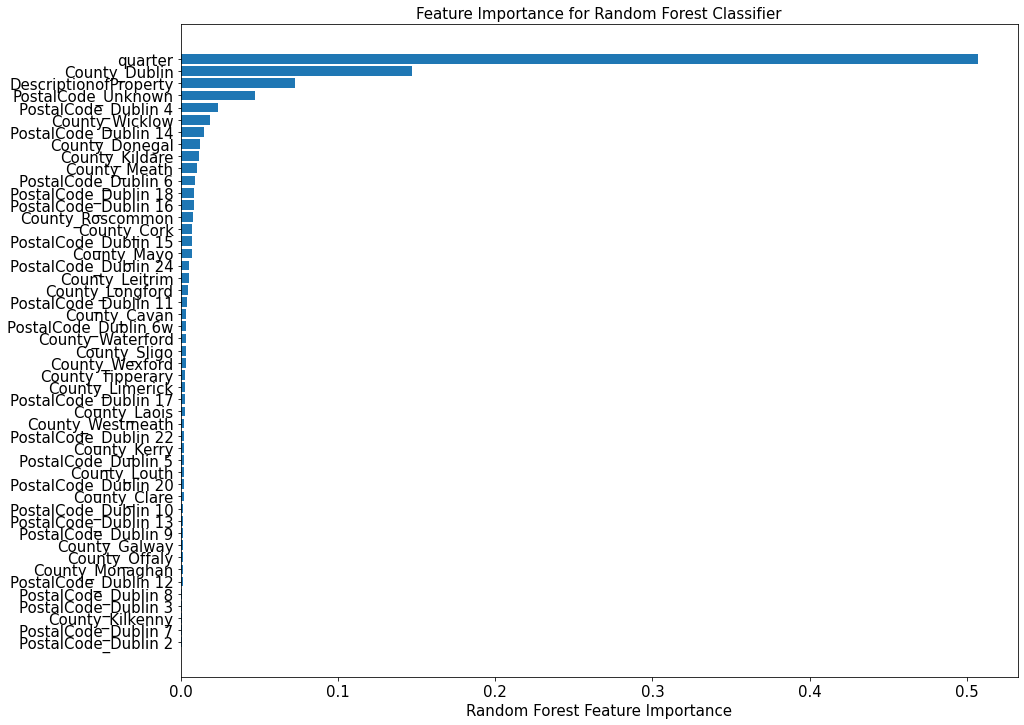

In [85]:
sorted_idx = forestClass.feature_importances_.argsort()
plt.figure(figsize=(15,12))
plt.barh(train[predictions].columns[sorted_idx], forestClass.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("Feature Importance for Random Forest Classifier")
plt.show()

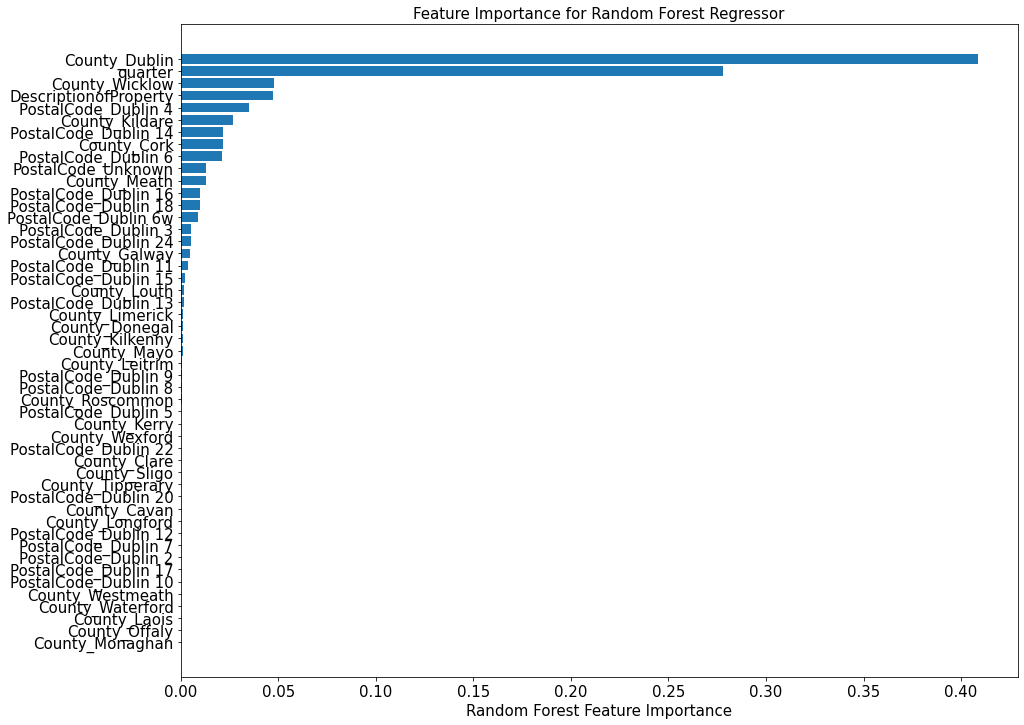

In [86]:
sorted_idx = forestReg.feature_importances_.argsort()
plt.figure(figsize=(15,12))
plt.barh(train[predictions].columns[sorted_idx], forestReg.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("Feature Importance for Random Forest Regressor")
plt.show()

<b>Interpretation of Random Forest Models</b>

As mentioned above and in the previous section, an important trade off exists in deciding concerning the maximum depth. In this case the depth determines how many 'questions' can be asked by the each tree comprising the Random Forest before an answer (i.e. prediction) must be reached. Choose too high and the trees will be far too specific to the training set and lack the generality for accurate predictions on new datasets. Too low and they won't capture the characteristics of all features in the model, also leading to inaccurate predictions. It was not surprising that the impact of this decision was similar to that of the Decision Trees above, with certain features determined to be unimportant excluded from the trees.

<u>Random Forest Classifier</u><br>
Once again a drawback of restricting the depth to 10 is that as we can see above not all of the features were incorporated into the model. The reason for this is quite simple - the features that were ignored simply do not play an important enough role in determining the price of the property. Looking at the graph itself we can see the most important feature was quarter, implying that a key determinant of the price will be the time it was sold. This is the same observation as what we saw for the Decision Tree Classifier. We can see this accounts for over 50% of the variability, which is quite high. I also note that the property being in Dublin plays a huge role in determining its price, again intuitive in that the most expensive (and most differently priced) properties were in the capital. This is all quite similar to the Decision Tree Classifier, and once again I note that some of the more expensive and larger Counties and Postal Codes have a greater role in determining the outcome of the predictions.

What is interesting is that with the same max depth a greater number of features are accounted for in the model than in one Decision Tree. This is likely due to more features playing a larger role in specific trees that comprise the Random Forest, which when added together gives a weighting a greater number of features.

<u>Random Forest Regressor</u><br>
In much the same way as the Random Forest Classifier, the Random Forest Regressor seems to strongly mirror its equivalent Decision Tree in terms of the importance weightings assigned to each feature. Again, being in Dublin and the quarter sold account for the two most important determinants of the price, accounting for almost 70% of the variability combined. It is also yet again the same features in both Classifier and Regressor models that account for the greatest importance - implying that the Gini Index/information gain is greatest from knowing if the property is in Dublin, the quarter it was sold in, if its new or old etc. Given that it is such few features that determine the prediction, I would not be surprised to see poor measures of evaluation, particularly the likes of RMSE which will inflate due to the presence of outliers.

Once again I note that although there are less features than in the Classifier model, using an ensemble of Decision Trees has led to a greater number of features having an importance in the Random Forest model than seeing in a single Decision Tree.
<br><br><br>
As with the Decision Tree models it's clear that only a few features directly impact the price prediction with these models i.e. the information gain is completely skewed towards County_Dublin, quarter and DescriptionofProperty (primarily). This is not a sign of a great model as there are clearly many other factors that go into the price of a property.

### 4.3 Evaluating the Model on the Training Set

In [87]:
forestClassPredictedTrain10 = forestClass.predict(train[predictions].head(10))
print("First 10 predictions with Random Forst Classification:")
predicted_df_train_class = pd.concat([train['quantiles'].head(10), pd.DataFrame(forestClassPredictedTrain10, columns=['Predicted Price Quantile'])], axis=1)
predicted_df_train_class

First 10 predictions with Random Forst Classification:


,quantiles,Predicted Price Quantile
0,0.9,0.8
1,0.4,0.1
2,0.1,0.1
3,0.8,0.8
4,0.3,0.1
5,0.2,0.2
6,0.5,0.1
7,0.3,0.3
8,0.1,0.2
9,0.9,1


In [88]:
forestRegPredictedTrain10 = forestReg.predict(train[predictions].head(10))
print("First 10 predictions with Random Forst Regression:")
predicted_df_train_reg = pd.concat([train[target].head(10), pd.DataFrame(forestRegPredictedTrain10, columns=['Predicted Price'])], axis=1)
predicted_df_train_reg

First 10 predictions with Random Forst Regression:


,Price(€),Predicted Price
0,402000.01,309856.695588
1,164000.00,114264.152347
2,49500.00,163869.593574
3,320070.00,237302.837051
4,115000.00,109745.297388
5,80000.00,161377.539828
6,200000.00,117228.438822
7,130000.00,219148.847518
8,40000.00,147530.509398
9,349999.95,424004.251119


Just like the two previous models we can see somewhat of a mixed bag in terms of accuracy. The Classification model is rarely correct but usually very close to the actual answer, while the Regression model is also generally close. One thing that I noted for the Decision Tree Regressor was that even in as small a sample as 10 there were quite a few prices that were the same, implying they had followed the same path. Knowing that the Random Forest is constructed using the majority output of multiple decision trees it is not surprising to see more variability in the predictions.

In [89]:
# predict entire training dataset using random forest class model
forestClassPredictedTrain = forestClass.predict(train[predictions])

In [90]:
# predict entire training dataset using random forest regressor model
forestRegPredictedTrain = forestReg.predict(train[predictions])

In [91]:
print("Confusion matrix: \n", metrics.confusion_matrix(train['quantiles'], forestClassPredictedTrain))
print("\u0332".join("\nClassification Report for Training Set"))
print(classification_report(train['quantiles'], forestClassPredictedTrain))

Confusion matrix: 
 [[461  83  37  27  10  15   5   5   4  10]
 [196 305  44  29  19  19  11   9   3  20]
 [189 102 208  34  23  41  17  14  11  29]
 [146  94  49 202  19  42  23  11  20  44]
 [110  87  48  53 155  51  34  14  26  75]
 [ 82  77  45  43  35 185  38  31  45  77]
 [ 48  66  37  39  27  62 181  28  61  99]
 [ 40  55  26  24  33  58  29 181  92 121]
 [ 26  39  18  30  20  34  25  36 291 140]
 [ 14  17   8  11  10  27  24  23  62 453]]

̲C̲l̲a̲s̲s̲i̲f̲i̲c̲a̲t̲i̲o̲n̲ ̲R̲e̲p̲o̲r̲t̲ ̲f̲o̲r̲ ̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲S̲e̲t
              precision    recall  f1-score   support

         0.1       0.35      0.70      0.47       657
         0.2       0.33      0.47      0.39       655
         0.3       0.40      0.31      0.35       668
         0.4       0.41      0.31      0.35       650
         0.5       0.44      0.24      0.31       653
         0.6       0.35      0.28      0.31       658
         0.7       0.47      0.28      0.35       648
         0.8       0.51      0.27     

In [92]:
print("\u0332".join("Regression Evaluation Measures for Training Set"))
RegressionMetrics(train[target], forestRegPredictedTrain, predictors, train.shape[0])

R̲e̲g̲r̲e̲s̲s̲i̲o̲n̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲a̲s̲u̲r̲e̲s̲ ̲f̲o̲r̲ ̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲S̲e̲t
MAE: 85199.19434583878
RMSE: 120033.04772889247
R2: 0.5146788764779127
Adjusted R2: 0.5110236758857543


<u>Random Forest Classifier</u><br>
- The <b>confusion matrix</b> shows a significant number of incorrect predictions for the training set, with the model in every case predicting a few properties in each of the incorrect quantiles. Generally however, there is a concentration along the diagonal as one would hope for, along with a significant number of predictions falling either side of the diagonal. Indeed the concentration along the diagonal is greater than what was seen for the equivalent on the Decision Tree model.
- <b>Accuracy</b> of 0.40 implies the model correcty predicted the quantile 40% of the time. This is much better than the 29% accuracy in the Decision Tree model.
- As the higher <b>precision</b> scores are typically skewed towards upper quantiles this implies that when the model predicts a price to be in a higher quantile it is more likely to truly be there than when it predicts it to be in a lower quartile. Once again this is similar to the Decision Tree model.
- The <b>recall</b> scores look to be highest for the upper and lower quantiles. This implies that if a price is truly in an upper or lower quartile the model is more likely to predict these correctly. This is the same trend seen in the Decision Tree model although the scores here are much better.
- <b>F1</b> scores are reasonable, and are a combination of the precision and recall.
- Overall the scores are much better than seen in the Decision Tree model. While leaving scope for improvement it will also be interesting to see what happens once the model is generalised.

<u>Random Forest Regressor</u><br>
- <b>MAE:</b> is sligtly lower than that of the linear regression model (the best model so far) for the training set (€85k vs €93k). This implies there are less errors overall in this model. It is also marginally better than the Decision Tree model. 
- <b>RMSE:</b> Also lower than the linear regression model (€120k vs €132k). Again this implies lower errors in this model, in particular the prevalence of larger errors (outliers) which are amplified in this model. It is also marginally better than the Decision Tree model. 
- <b>R<sup>2</sup>:</b> Better than that of the linear regression model (0.51 vs 0.41), telling us that more of the variation in the actual value is being captured by the variation in the independent variables. It is also marginally better than the Decision Tree model. 
- Overall this hints at a better model than that of the linear regression model but we will need to see how it generalises.

### 4.4 In Depth Model Evaluation on the Test Set

In [93]:
forestClassPredictedTest = forestClass.predict(test[predictions])
print("Confusion matrix: \n", metrics.confusion_matrix(test['quantiles'], forestClassPredictedTest))
print("\u0332".join("\nClassification Report for Test Set"))
print(classification_report(test['quantiles'], forestClassPredictedTest))

Confusion matrix: 
 [[147  61  31  16   7   9   7   3   1   3]
 [111  69  33  22  11  21   3   7   3   6]
 [109  52  29  22  14  14  12   7   5  14]
 [ 71  65  34  30  20  17  19  13   9  16]
 [ 47  39  31  30  21  27  17   7  10  35]
 [ 35  44  13  29  20  24  26  12  26  36]
 [ 23  39  15  22  21  28  31  19  35  49]
 [ 12  18  14  16  15  20  28  36  45  64]
 [ 13  21   7  14  14  20  18  26  72  94]
 [  3   7   6   3  10  14  16  19  70 141]]

̲C̲l̲a̲s̲s̲i̲f̲i̲c̲a̲t̲i̲o̲n̲ ̲R̲e̲p̲o̲r̲t̲ ̲f̲o̲r̲ ̲T̲e̲s̲t̲ ̲S̲e̲t
              precision    recall  f1-score   support

         0.1       0.26      0.52      0.34       285
         0.2       0.17      0.24      0.20       286
         0.3       0.14      0.10      0.12       278
         0.4       0.15      0.10      0.12       294
         0.5       0.14      0.08      0.10       264
         0.6       0.12      0.09      0.10       265
         0.7       0.18      0.11      0.14       282
         0.8       0.24      0.13      0.17   

In [94]:
# predict entire test dataset using random forest regressor model
forestRegPredictedTest = forestReg.predict(test[predictions])
print("\u0332".join("Regression Evaluation Measures for Test Set"))
RegressionMetrics(test[target], forestRegPredictedTest, predictors, test.shape[0])

R̲e̲g̲r̲e̲s̲s̲i̲o̲n̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲a̲s̲u̲r̲e̲s̲ ̲f̲o̲r̲ ̲T̲e̲s̲t̲ ̲S̲e̲t
MAE: 93216.67013651755
RMSE: 130541.49584979725
R2: 0.39381407161493787
Adjusted R2: 0.3830520750602755


Testing the models againt the test set indicates how well they generalise to unseen data. Were the depth of the model set too high the models would not generalise well as the answers it was predicting correctly in the training set would likely just be specifically learned predictions.

<u>Random Forest Classifier</u><br>
- The <b>confusion matrix</b> looks to be in much worse shape than what was seen for the training set. Although there is still a concentration down the diagonal the results are definitely more dispersed around the indexes on the diagonal, indicating that there were a lot more predictions close to correct but not quite.
- <b>Accuracy</b> of 0.21 implies the model correcty predicted the quantile 21% of the time. This is lower than the 40% seen in the training set, and only 11% higher than what you would expect if you were to randomly guess the quantile. It also matches the accuracy score of the Decision Tree model when applied to the test set.
- The <b>precision</b> scores show the same trend in being higher for the upper quantiles. They are generally lower however, indicating that when the model predicts a price to be in a specific quantile it is less likely to truly be there.
- The <b>recall</b> scores are generally poorer across the board, indicating that the model is less likely to predict that a price is in a specific quantile if it is actually there.
- <b>F1</b> scores are again quite poor and are a combination of the precision and recall. They are also slightly worse than those seen for the Decision Tree model
- Overall the scores are much worse than what we saw for the trained dataset, indicating that the generalisation of the model is not the best. It generalises quite similarly to that of the Decision Tree Model.

<u>Random Forest Regressor</u><br>
- <b>MAE:</b> is much higher than that of the training MAE (€93k vs €85k). Indeed it is also in line with the MAE for the linear regression model for the test set, which showed little variation between the train and test. This implies that this model is more specific to the training set.
- <b>RMSE:</b> Also much higher than the training RMSE (€130k vs €120k) showing there is a greater presence of errors and outliers when applied to the test set. It is marginally better than the test set application of the Decision Tree model.
- <b>R<sup>2</sup>:</b> Better than that of the decision tree model equivalent (0.39 vs 0.35). Very much in line with the linear regression model.
- Overall the model showed a relatively poor ability to generalise to this unseen dataset. The differences in the evaluation measures between the train and test for the Linear Regression model were much lower than what we saw here. However, that being said its worth noting that the evaluation metrics for the Random Forest Regression model are very similar to the Linear Regression model for the test set, and the Random Forest performs better than the Linear Regression on the training data. 

In [95]:
kfoldForestClass = cross_val_score(RandomForestClassifier(n_estimators=100, max_depth=10, max_features='auto', oob_score=True, 
                        random_state=1), entire_dataset2[predictions], entire_dataset2['quantiles'], cv=10)

In [96]:
print("\u0332".join("\nModel Accuracy for cross validation of Random Forest Classifier: 10 Folds"))
forest_class_df = pd.DataFrame()
forest_class_df['Fold'] = [x for x in range(1,11)]
forest_class_df['Model Accuracy'] = kfoldForestClass
ave_row_forest_class = {'Fold':'Average', 'Model Accuracy':forest_class_df['Model Accuracy'].mean()}
forest_class_df = forest_class_df.append(ave_row_forest_class, ignore_index=True)
forest_class_df =forest_class_df.style.apply(highlight_last)
forest_class_df


̲M̲o̲d̲e̲l̲ ̲A̲c̲c̲u̲r̲a̲c̲y̲ ̲f̲o̲r̲ ̲c̲r̲o̲s̲s̲ ̲v̲a̲l̲i̲d̲a̲t̲i̲o̲n̲ ̲o̲f̲ ̲R̲a̲n̲d̲o̲m̲ ̲F̲o̲r̲e̲s̲t̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r̲:̲ ̲1̲0̲ ̲F̲o̲l̲d̲s


,Fold,Model Accuracy
0,1,0.205977
1,2,0.225187
2,3,0.219851
3,4,0.230523
4,5,0.199573
5,6,0.216649
6,7,0.209402
7,8,0.202991
8,9,0.219017
9,10,0.237179


In [97]:
kfoldForestReg = cross_validate(RandomForestRegressor(n_estimators=100, max_depth=10, max_features='auto', oob_score=True, 
                random_state=1), entire_dataset2[predictions], entire_dataset2[target], scoring=testMetrics, cv=10)

In [98]:
print("\u0332".join("\nRegression Evaluation Measures for cross validation of Random Forest Regressor: 10 Folds"))
df_cross_validate = pd.DataFrame()
df_cross_validate['Fold'] = [x for x in range(1,11)]
df_cross_validate['MAE'] = -kfoldForestReg['test_neg_mean_absolute_error']
df_cross_validate['RMSE'] = -kfoldForestReg['test_neg_mean_squared_error']
df_cross_validate['RMSE'] = df_cross_validate['RMSE'].apply(lambda val: math.sqrt(val))
df_cross_validate['R2'] = kfoldForestReg['test_r2']

ave_row_forest_reg = {'Fold':'Average', 'MAE':df_cross_validate['MAE'].mean(), 'RMSE':df_cross_validate['RMSE'].mean(),
           'R2':df_cross_validate['R2'].mean()}

df_cross_validate = df_cross_validate.append(ave_row_forest_reg, ignore_index=True)
df_cross_validate =df_cross_validate.style.apply(highlight_last)

df_cross_validate


̲R̲e̲g̲r̲e̲s̲s̲i̲o̲n̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲a̲s̲u̲r̲e̲s̲ ̲f̲o̲r̲ ̲c̲r̲o̲s̲s̲ ̲v̲a̲l̲i̲d̲a̲t̲i̲o̲n̲ ̲o̲f̲ ̲R̲a̲n̲d̲o̲m̲ ̲F̲o̲r̲e̲s̲t̲ ̲R̲e̲g̲r̲e̲s̲s̲o̲r̲:̲ ̲1̲0̲ ̲F̲o̲l̲d̲s


,Fold,MAE,RMSE,R2
0,1,94459.518008,133283.941786,0.356689
1,2,92888.175998,136835.499779,0.389220
2,3,95399.329609,139680.066735,0.365029
3,4,93563.241025,132379.033471,0.402948
4,5,95614.764254,135648.433686,0.404798
5,6,92431.080312,134003.703270,0.407780
6,7,91905.522232,128261.374241,0.415618
7,8,93055.733978,134939.259329,0.399227
8,9,95003.737818,135445.751409,0.382718
9,10,91424.851925,122335.763279,0.383791


<b>Discussion of Cross Validation Results</b>

Looking at the cross validation results there is little evidence to suggest that the original evaluation measures seen for each model applied to the test sets were inaccurate. The accuracy scores for the Random Forest Classifier are generally stable at around 0.22, indicating that our model will only be correct for unseen data 22% of the time, only over double that of what we would expect for a guess. Meanwhile the MAE, RMSE and R<sup>2</sup> are all very much in line to those for the Linear Regression model (although the Random Forest is very marginally worse).

Overall it was disappointing to see significantly better performance in the training dataset than the test. This was seen for both the Random Forest and Decision Tree models and implies that they are poor at generalising and indicate overfitting. Additionally, as we saw above, the vast majority of information gain for both types of models came from a very small subset of the features, which could lead to an argument of overreliance. On the training set this model performed better than the linear regression, but lost the advantage when compared to the test. Due to the fact that there is a loss once generalised, combined with the fact that the Linear Regression performs marginally better on cross validation, I believe the Linear Regression model is the best of the three.

<b>Out-of-Sample Error</b>

As mentioned above, random forest uses ensembling to combine different decision trees into the complete model. The specific ensembling technique used is termed 'bagging', and it helps to reduces variance in training a noisy dataset (such as the one I am using). At its core, bagging helps to compensate for errors in each decision tree by looking at the bigger picture of all decision trees combined. The out-of-bag (OOB) error term is the average error for each observation from the trees that do not contain that specific observation, essentially allowing for validation during training. It is therefore computed on data not included in the model, and can thus be compared to cross validation results (as these measures are computed on data also not included in the model).

In [99]:
print("Out-of-bag score for the Random Forest Classificaton model is", round(forestClass.oob_score_,3))
print("Out-of-bag score for the Random Forest Regressor model is", round(forestReg.oob_score_,3))

Out-of-bag score for the Random Forest Classificaton model is 0.215
Out-of-bag score for the Random Forest Regressor model is 0.384


For the Classification model we can see that the OOB score is extremely close to that of the cross validation results. As it is slightly lower however, there is a slight indication that the model was overfit during training. 

The OOB score for the Regressor model is very similar to the R<sup>2</sup> value seen in cross validation. This is intuitive as the OOB score was calculated on the average of observations not included in Decision Trees that comprise the Random Forest (and so if effectively another test set), so this helps to verify the accuracy of our cross validation results.

## Part 5

### 5.1 Choosing the Best Model & Testing Against a Model that Predicts the Yearly Average

<b>Summary of Models Trained</b>

Following my analysis of the Linear Regression model I had assumed that it would be the worst of the 3 models due to the poor regression evaluation metrics seen. However, as seen it actually stacks up quite well versus those of the Decision Tree and Random Forest models. Given the extremely wide and diverse distribution of prices any model will struggle to get high accuracy with such few features. Below I have prepared a table of the Cross Validation evaluation measures for the 3 regression models for reference. This shows the average of the evaluation metrics for each of the folds.

In [100]:
summary_df = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'R2'])
summary_df = summary_df.append(ave_row_lin_reg, ignore_index=True)
summary_df = summary_df.append(ave_row_tree_reg, ignore_index=True)
summary_df = summary_df.append(ave_row_forest_reg, ignore_index=True)
summary_df = summary_df.drop(columns=['Fold'])
summary_df.loc[0,'Model'] = 'Linear Regression'
summary_df.loc[1,'Model'] = 'Decision Tree Regression'
summary_df.loc[2,'Model'] = 'Random Forest Regression'
summary_df

,Model,MAE,RMSE,R2
0,Linear Regression,93643.023072,132002.853224,0.402773
1,Decision Tree Regression,96137.227946,137411.429134,0.351673
2,Random Forest Regression,93574.595516,133281.282698,0.390782


- <b>Linear Regression:</b>Based on both the RMSE and R<sup>2</sup> the Linear Regression Model comes out on top. A further promising aspect of this model was the good generalisation seen between the training and test data - the evaluation measures did not really drop when generalised. This shows that the model didn't just 'learn' specific predictions.
- <b>Decision Tree Regression:</b> This was the worst of the 3 models. It showed significantly better evaluation measures for the training set but did not generalise well. This was after careful selection of the maximum depth so as to minimise this difference while at the same time achieving relatively strong results. It shows that the model is too specific to the training set. Clearly however, there isn't a huge difference in the measures between the other two models but does stand out as the worst in any case.
- <b>Random Forest Regression:</b> I believe this was a close second in terms of the best model seen in predicting house prices. It has the best MAE score when applied to the test set, although only marginally and it is likely the case that this difference is not statistically significant. With a higher RMSE this implies that there are more outliers in the error terms than the Linear Regression model.


The Linear Regression model has the highest R<sup>2</sup> and RMSE value, and additionally shows the highest stability in regression evaluation metrics when applied to the test set. In addition I observed a significant level of reliance on just a few metrics such as 'quarter', 'County_Dublin' and 'DescriptionofProperty' in both the Decision Tree and Random Forest models, with upwards of 70% of the importance placed on these terms alone. There should be more scope to add more features to the Linear Regression model that have a good chance of improving the price predictions for those properties that are not in Dublin, not new etc.

<b>Best Model: Linear Regression - Reminder of Performance</b>

As a reminder, below I have printed the coefficient values calculated for the linear regression model. Once again it is interesting to note that identifying as an even numbered postal code has the highest weighting in those model, something that was largely missed from the importance of the other two models (although still scoring highly). Also of note is the negative values from some of the less expensive postal codes, clearly capturing some more nuance and specificity that was not seen in the Decision Tree and Random Forest models which largely ignored these features.

'quarter' and 'DescriptionofProperty' play a significant role in determining the prediction, but do not completely dominate the outcome. It seems as though there is more scope for capturing the nuance of various aspects that impact the property price via this Linear Regression model than would be possible in a tree based model which is more likely to learn the outcomes for specific inputs that can see large variability once they change to a slight degree.

In [101]:
print("\u0332".join("\nReminder of Coefficients for the Linear Regression model"))
linreg_display_df.sort_values('Coefficient', ascending=False)


̲R̲e̲m̲i̲n̲d̲e̲r̲ ̲o̲f̲ ̲C̲o̲e̲f̲f̲i̲c̲i̲e̲n̲t̲s̲ ̲f̲o̲r̲ ̲t̲h̲e̲ ̲L̲i̲n̲e̲a̲r̲ ̲R̲e̲g̲r̲e̲s̲s̲i̲o̲n̲ ̲m̲o̲d̲e̲l


,Feature,Coefficient
41,PostalCode_Dublin 4,317546.510801
44,PostalCode_Dublin 6w,282733.377066
43,PostalCode_Dublin 6,279439.951395
31,PostalCode_Dublin 14,265373.683130
6,County_Dublin,216078.953006
33,PostalCode_Dublin 16,182254.183883
26,County_Wicklow,180704.133505
35,PostalCode_Dublin 18,163931.551800
40,PostalCode_Dublin 3,147738.321448
9,County_Kildare,113336.654895


<b>Comparison of Linear Regression model against one that predicts the mean Price for the Year</b>

Below I have calculated the mean property price for each year in the training set and assigned it as a prediction for the price to compare to the behaviour of my Linear Regression model.

Due to the nature of the encoding chosen my date feature is now just a quarter, beginning at 0, the first representing 2010Q1. I will therefore have to loop through these in groups of 4 representing each year in the dataset.

In [102]:
# list of means for the years, value at index of 0 will represent 2010 and so on
yearMeans = []
# max quarter in the dataset
maxQ = train['quarter'].max()
# loop through the quarter numbers in jumps of 4
for quarterNum in range(3, maxQ+4, 4):
    # make a temporary dataframe for each range of quarter that correspond to a years worth of quarters
    yeardfUpper = train[train['quarter']<=quarterNum]
    yeardfLower = yeardfUpper[train['quarter']>quarterNum-4]
    # get the mean of the price of this temp df 
    meanYear = yeardfLower['Price(€)'].mean()
    yearMeans.append(meanYear)

yearMeans

/var/folders/sk/nrbzmqq1715frfmf08t0c02c0000gn/T/ipykernel_31918/3541009936.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  yeardfLower = yeardfUpper[train['quarter']>quarterNum-4]


[231327.33944444443,
 208831.60843881854,
 199650.06984126984,
 182482.41121761655,
 195235.002414966,
 216325.10174679488,
 226820.7376019576,
 245386.40152974508,
 264594.2153824363,
 273845.82517369726,
 270235.3147819063,
 306131.2295021962,
 368333.3333333333]

The above list the average property price in each year, beginning in 2010, up to 2022. Below I have made a copy of the test dataframe, keeping only the Price(€) and quarter features. I then looped through this dataframe, dividing the quarter cleanly by 4 to get the year in terms of the index of the above list. I then assigned the appropriate mean value to each row.

In [103]:
testModelMeans = test.copy()

In [104]:
# only keep Price(€) and quarter features
testModelMeans = testModelMeans.drop(columns=[feature for feature in list(testModelMeans.columns) 
                             if (feature != 'Price(€)'and feature!='quarter')])

In [105]:
# iterate through rows
for index, row in testModelMeans.iterrows():
    # find the index that the relevant mean is located at in the yearIndex list
    yearIndex = int(row['quarter'] // 4)
    testModelMeans.loc[index, 'MeanPrediction'] = yearMeans[yearIndex]

testModelMeans

,Price(€),quarter,MeanPrediction
0,367000.0,45,306131.229502
1,215000.0,20,216325.101747
2,230000.0,7,208831.608439
3,236000.0,2,231327.339444
4,108392.5,19,195235.002415
...,...,...,...
2805,259000.0,19,195235.002415
2806,250000.0,5,208831.608439
2807,279000.0,33,264594.215382
2808,110000.0,29,245386.401530


We can see above that a dataframe has now been created with a prediction for each row that is the average price of a property sold in that year in the training dataset. I will now compute evaluation measures on this prediction.

Next I use the RegressionMetrics function I created earlier to calculate regression evaluation measures. Note I am passing it 2 as the number of predictors as it is only year and price that impact the prediction - as a reminder this is used in the calculation of R<sup>2</sup>.

In [106]:
RegressionMetrics(testModelMeans[target], testModelMeans['MeanPrediction'], 2, testModelMeans.shape[0])

MAE: 119651.91613369822
RMSE: 162018.64436763056
R2: 0.06623268295939366
Adjusted R2: 0.06556736958779363


It is clear from above that a model that predicts the price of a property using only the mean property price of the year of sale in the training set is an exceptionally poor model. The R<sup>2</sup> here is a more 0.07, meaning that we can say only 7% of the variation observed in the actual price can be explained by the variation in the predictors. This is much less than the linear regression model which had an R<sup>2</sup> of 38% when applied to the test set (and 40% in cross validation), meaning we can be much more confident in its predictions, even if 41% is not that high. The MAE and RMSE are also both significantly large, implying there are a lot of large error terms in the residuals.

My linear regression is obviously much better, with a much higher R<sup>2</sup> and significantly lower MAE and RMSE values.

### 5.2 Model Summary & Improvement

It is fair to say that I was quite critical of my initial implementation of my Linear Regression model. I had expected both tree based models to significantly outperform, especially based on what I had thought were relatively poor results. However it is worth considering the following:

- Both the Random Forest and Decision Tree models showed me that a lot of the encoded data on Counties and Postal Codes was not being fully used - there were some very low importance scores seen across a huge number of features.
- When predicting a price a property is sold for a considerable number of data points would typically be factored in. Unlike a Tree based model where the importance of one or two features can be overweighted, a Linear Regression model allows for large weightings even for characteristics that are rare in the training dataset. For example, properties sold in County Monaghan have very few entries and therefore may pose little opportunity to pose importance in a tree based model, and indeed we saw above that in some cases it was impossible to see this feature on the importance charts. In a Linear Regression model, even if only a few training datapoints are in County Monaghan, ideally its pricing traits would be captured in its one coefficient.
- Sticking to the point of features required, it is disappointing that we do not have information on the specifics of the properties, such as number of bedrooms, size (more specific and more inclusive than the size feature we do have), condition it is in etc. Clearly these factors will all play a significant role in the price and would easily help to reduce the errors seen in the evaluation measures.
- While I initially dismissed the Linear Regression model as poor, I have since considered the variance in the dataset and the impossible nature of accurately predicting the price for all properties. With such a large dataset with as wide a range of possible predictions that there are, it is not surprising that significant error was seen the residuals.

<b>Ideas for Improvement</b>

<b>1)</b> A common theme I observed in all of the models was certain Counties and Postal Codes posing little impact on the outcome of predictions. As mentioned above, the Linear Regression model does allow for specificity regarding the coefficients of these terms, but it has opened my eyes to the realisation that a lot of these features have very low category counts. I will therefore combine some of these, and see the impact it has on both my Linear Regression model, and out of interest, my Random Forest Regression model (my best Tree based model).<br>
<b>2)</b> A huge factor in the price of properties is the macro economy at large. I may have been too quick to dismiss my measure of the economy previously in the form of stock prices. However, it is fair to say that the Stock Market is typically regarded as a lagging indicator. I will therefore use stock prices from six months ago as an indicator of todays price. This will allow for property price predictions six months into the future. If the prices were not lagged we would not be able to predict a price for tomorrow.<br>
<b>3)</b> Throughout my analysis I noted very high RMSE scores for the regression based models. This is indicative of large outliers. I note in Homework 1 my work on eliminating outliers focused on outliers above the mean, without consideration for the lower end. I will work on removing these in the same way the outliers were removed in Homework 1 (using log prices and standard deviation).<br><br>
<b>PropertySize:</b> As mentioned, I think there is scope for model improvement by adding in information regarding the size of the property. This information is provided in the 'PropertySizeDescription' feature, but as mentioned only for new properties, and in addition it seems to have been discontinued in more recent entries. As a proxy for this I will carry out the same regression as before, but only for those properties that have this information, to see how the model could improve with complete data.

Due to the fact that the transformations imposed on the dataset to date have removed some of the information required to make changes, I will now reload in the dataset once more.

In [107]:
# use commas as separator
# using converters argument so that Address field maintains lists from Assignment 1
clean_df_updated = pd.read_csv('datasets/PPRFileFinalVersion.csv', keep_default_na=True, delimiter=',', skipinitialspace=True, converters={'Address': literal_eval})

In [108]:
# dropping quarter number, address, property size description, town, older implementation of stock price, population, VATExclusive
clean_df_updated = clean_df_updated.drop(columns=['QuarterNumber', 'Address', 'VATExclusive', 'Town', 'StockPrice', 'Population'])

# converting quarter back to a Period datatype (info was lost loading dataset in)
clean_df_updated['quarter'] = pd.to_datetime(clean_df_updated['quarter']).dt.to_period('Q')

# converting to datetime and specifying the day comes first in original data
clean_df_updated['DateofSale(yyyy-mm-dd)'] = pd.to_datetime(clean_df_updated['DateofSale(yyyy-mm-dd)'], dayfirst=True)
clean_df_updated['DateofSale(yyyy-mm-dd)'] = clean_df_updated['DateofSale(yyyy-mm-dd)'].astype('datetime64[ns]')

categorical_cols = ["PostalCode", "County", "DescriptionofProperty", "PropertySizeDescription"]
for feature in categorical_cols:
    clean_df_updated[feature] = clean_df_updated[feature].astype('category')

In [109]:
# replacing NaN with 'Unknown'
clean_df_updated['PostalCode'] = clean_df_updated['PostalCode'].cat.add_categories('Unknown')
clean_df_updated['PostalCode'] = clean_df_updated['PostalCode'].fillna('Unknown')

# drop price column
clean_df_updated = clean_df_updated.drop(columns=['Price(€)'])
# drop rows without a CleanedPrice(€)
clean_df_updated = clean_df_updated.dropna(subset=['CleanedPrice(€)'])

# rename CleanedPrice(€) back to the original Price(€)
clean_df_updated.rename(columns={'CleanedPrice(€)':'Price(€)'},inplace=True)

In [110]:
clean_df_updated = clean_df_updated[clean_df_updated["NotFullMarketPrice"].str.contains("Yes") == False]
clean_df_updated = clean_df_updated.drop(columns=['NotFullMarketPrice'])

<b>Including Property Size in Model</b> 

I will now carry out my analysis on the impact of including PropertySizeDescription in my model. As mentioned this will not be included in any further predictions as the feature has not populated in recent times. However, it should provide a proxy as to the better predictions we can obtain with this important information. 

In [111]:
# replacing NaN with 'Unknown'
clean_df_updated['PropertySizeDescription'] = clean_df_updated['PropertySizeDescription'].cat.add_categories('Unknown')
clean_df_updated['PropertySizeDescription'] = clean_df_updated['PropertySizeDescription'].fillna('Unknown')
# setting proxy_df to equal only those rows that are populated with a size
proxy_df = clean_df_updated[clean_df_updated["PropertySizeDescription"].str.contains("Unknown") == False]

Noted already that there are no properties with a PropertySizeDescription that are second hand so I will remove DescriptionofProperty. I also do not need the date column for this analysis.

In [112]:
proxy_df = proxy_df.drop(columns=['DescriptionofProperty','DateofSale(yyyy-mm-dd)'])
proxy_df

,PostalCode,County,PropertySizeDescription,Price(€),quarter
0,Unknown,Galway,between 38 and 125 sq metres,90575.00,2017Q3
2,Unknown,Louth,greater than or equal to 125 sq metres,347066.11,2010Q2
7,Unknown,Dublin,between 38 and 125 sq metres,265000.93,2012Q2
8,Unknown,Cork,greater than or equal to 125 sq metres,338623.96,2010Q2
13,Unknown,Wexford,between 38 and 125 sq metres,129999.99,2011Q4
...,...,...,...,...,...
9900,Unknown,Donegal,greater than or equal to 125 sq metres,60000.00,2016Q4
9906,Unknown,Meath,between 38 and 125 sq metres,240886.73,2017Q2
9920,Unknown,Galway,greater than or equal to 125 sq metres,186140.00,2012Q1
9923,Unknown,Longford,between 38 and 125 sq metres,29999.19,2012Q4


Can see above that there are only 1010 columns with a Property Size populated. This will make modelling less accurate as there is a smaller size, however, this is still a lot and I would hope for improvemed results.

I will now encode the columns as appropriate.

In [113]:
# encode counties
countyDummies = pd.get_dummies(proxy_df['County'], prefix='County', drop_first=True)
proxy_df = pd.concat([proxy_df, countyDummies], axis=1)
proxy_df = proxy_df.drop(columns=['County'])

# encode postal codes
postalDummies = pd.get_dummies(proxy_df['PostalCode'], prefix='PostalCode', drop_first=True)
proxy_df = pd.concat([proxy_df, postalDummies], axis=1)
proxy_df = proxy_df.drop(columns=['PostalCode'])

# encode quarters
proxy_df['quarter'] = encoder.transform(proxy_df['quarter'])

There are 3 categories of property sizes, in increasing order. The data is therefore clearly ordinal and I will encode them as such.

In [114]:
proxy_df['PropertySizeDescription'] = proxy_df['PropertySizeDescription'].apply(lambda x: 0 if x == "less than 38 sq metres" else (1 if x=="between 38 and 125 sq metres" else 2))

All features are now encoded so I will split the dataframe into training and testing datasets.

In [115]:
proxy_train, proxy_test = train_test_split(proxy_df, test_size=0.3, random_state=2)

In [116]:
# set a list of all column names except for Price(€)
proxyPredictions = [feature for feature in list(proxy_train.columns) if feature != 'Price(€)']

In [117]:
# fit the linear model
linregProxy = LinearRegression().fit(proxy_train[proxyPredictions], proxy_train[target])
proxy_linreg_display_df = pd.DataFrame()
proxy_linreg_display_df['Feature'] = proxyPredictions
proxy_linreg_display_df['Coefficient'] = linregProxy.coef_
intercept = linregProxy.intercept_
print("Intercept:", intercept)
print("\n Features & their coefficients")
proxy_linreg_display_df.sort_values('Coefficient', ascending=False)

Intercept: -81364.83267109905

 Features & their coefficients


,Feature,Coefficient
41,PostalCode_Dublin 4,7.739978e+05
43,PostalCode_Dublin 6,5.458146e+05
44,PostalCode_Dublin 6w,3.536441e+05
36,PostalCode_Dublin 2,2.860951e+05
31,PostalCode_Dublin 14,2.643045e+05
29,PostalCode_Dublin 12,2.509850e+05
42,PostalCode_Dublin 5,2.210973e+05
33,PostalCode_Dublin 16,1.960288e+05
6,County_Dublin,1.704054e+05
35,PostalCode_Dublin 18,1.566282e+05


In [118]:
# use the model to predict values for training set
predictedProxyTrain = linregProxy.predict(proxy_train[proxyPredictions])

In [119]:
predictorsProxy = proxy_train[proxyPredictions].shape[1]
print("\u0332".join("Regression Evaluation Measures for Training Set including Property Size"))
RegressionMetrics(proxy_train[target], predictedProxyTrain, predictorsProxy, proxy_train.shape[0])

R̲e̲g̲r̲e̲s̲s̲i̲o̲n̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲a̲s̲u̲r̲e̲s̲ ̲f̲o̲r̲ ̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲S̲e̲t̲ ̲i̲n̲c̲l̲u̲d̲i̲n̲g̲ ̲P̲r̲o̲p̲e̲r̲t̲y̲ ̲S̲i̲z̲e
MAE: 88034.32096081781
RMSE: 118617.03148977882
R2: 0.5134699010427382
Adjusted R2: 0.47718379016160295


In [120]:
predictedProxyTest = linregProxy.predict(proxy_test[proxyPredictions])
print("\u0332".join("Regression Evaluation Measures for Test Set including Property Size"))
RegressionMetrics(proxy_test[target], predictedProxyTest, predictorsProxy, proxy_test.shape[0])

R̲e̲g̲r̲e̲s̲s̲i̲o̲n̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲a̲s̲u̲r̲e̲s̲ ̲f̲o̲r̲ ̲T̲e̲s̲t̲ ̲S̲e̲t̲ ̲i̲n̲c̲l̲u̲d̲i̲n̲g̲ ̲P̲r̲o̲p̲e̲r̲t̲y̲ ̲S̲i̲z̲e
MAE: 86981.46211856678
RMSE: 115972.04395597531
R2: 0.49087922087315106
Adjusted R2: 0.3922748012003622


In [121]:
# conducting cross validation
# setting cv to 3 given the small dataset
kfoldProxy = cross_validate(LinearRegression(), proxy_df[proxyPredictions], proxy_df[target], scoring=testMetrics, cv=3)

In [122]:
df_cross_validate = pd.DataFrame()
df_cross_validate['Fold'] = [x for x in range(1,4)]
df_cross_validate['MAE'] = -kfoldProxy['test_neg_mean_absolute_error']
df_cross_validate['RMSE'] = -kfoldProxy['test_neg_mean_squared_error']
df_cross_validate['RMSE'] = df_cross_validate['RMSE'].apply(lambda val: math.sqrt(val))
df_cross_validate['R2'] = kfoldProxy['test_r2']

ave_row_lin_reg_proxy = {'Fold':'Average', 'MAE':df_cross_validate['MAE'].mean(), 'RMSE':df_cross_validate['RMSE'].mean(),
           'R2':df_cross_validate['R2'].mean()}

df_cross_validate = df_cross_validate.append(ave_row_lin_reg_proxy, ignore_index=True)
df_cross_validate =df_cross_validate.style.apply(highlight_last)

df_cross_validate

,Fold,MAE,RMSE,R2
0,1,88857.739476,121154.822383,0.418890
1,2,97721.022851,134237.524835,0.414311
2,3,93328.958299,123270.513099,0.465207
3,Average,93302.573542,126220.953439,0.432803


The results here are striking, proving the increased accuracy of predictions by virtue of including more relevant data.

- The model struggled somewhat due to the smaller sample size and the number of columns. We can see evidence in the difference between adjusted R<sup>2</sup> and R<sup>2</sup>. Up to now we had never seen much of a discrepancy between these numbers.
- Nevertheless the adjusted R<sup>2</sup> for both the training and testing data is higher than what we saw for the linear regression on the dataset without Property Size Description.
- There are clear limitations in applicability of these findings since this feature is not reported any more for new properties sold. However, it shows the scope for model improvement if we did get this information.
- Indeed the range of sizes available is quite broad. If we were to somehow get continuous data on property size, or simply more categories, there could be significant scope for model improvement.
- Below are the value counts for the entire dataset. Almost all properties are in the 'between 38 and 125 sq metres'. Even still, separating them slightly has resulted in a significant improvement in prediction accuracy. This is quite remarkable.
- The coefficient on PropertySizeDescription is €49,162. This is quite large and shows the distribution differences in price depending on the size of the property.

Unfortunately these results cannot be brought forward due to a lack of data but it was nevertheless an interesting exploration.

In [123]:
proxy_df['PropertySizeDescription'].value_counts(dropna=False)

1    755
2    198
0     57
Name: PropertySizeDescription, dtype: int64

<b>Implementing Potential Model Improvements</b>

Following the above exploration I will now add the 4 extra features discussed at the beginning of this section. I first need to encode the dataframe as appropriate, and split it into training and testing.

In [124]:
# dropping PropertySizeDescription
clean_df_updated = clean_df_updated.drop(columns=['PropertySizeDescription'])

# encode quarters
clean_df_updated['quarter'] = encoder.transform(clean_df_updated['quarter'])

clean_df_updated['DescriptionofProperty'] = clean_df_updated['DescriptionofProperty'].apply(lambda x: 1 if x == "New Dwelling house /Apartment" else 0)

In [125]:
clean_df_updated

,DateofSale(yyyy-mm-dd),PostalCode,County,DescriptionofProperty,Price(€),quarter
0,2017-08-01,Unknown,Galway,1,90575.00,30
1,2017-08-28,Dublin 6,Dublin,0,515000.00,30
2,2010-06-17,Unknown,Louth,1,347066.11,1
3,2020-12-18,Dublin 8,Dublin,0,345000.00,43
4,2019-02-08,Dublin 5,Dublin,0,390000.00,36
...,...,...,...,...,...,...
9993,2019-11-15,Unknown,Kildare,1,327499.99,39
9994,2017-04-27,Unknown,Galway,0,250000.00,29
9995,2018-03-27,Dublin 18,Dublin,0,485000.00,32
9996,2019-02-26,Unknown,Kilkenny,0,170000.00,36


<b>Improvement #1: Reducing the Range of Counties and Postal Codes</b>

I will now take another look at the distribution of prices amongst the counties and Postal Codes, as well as the importances placed upon these in previous modelling efforts.

In [126]:
# make a copy of the dataframe as we do not know if the changes made will be beneficial
copy_clean_df_updated = clean_df_updated.copy()

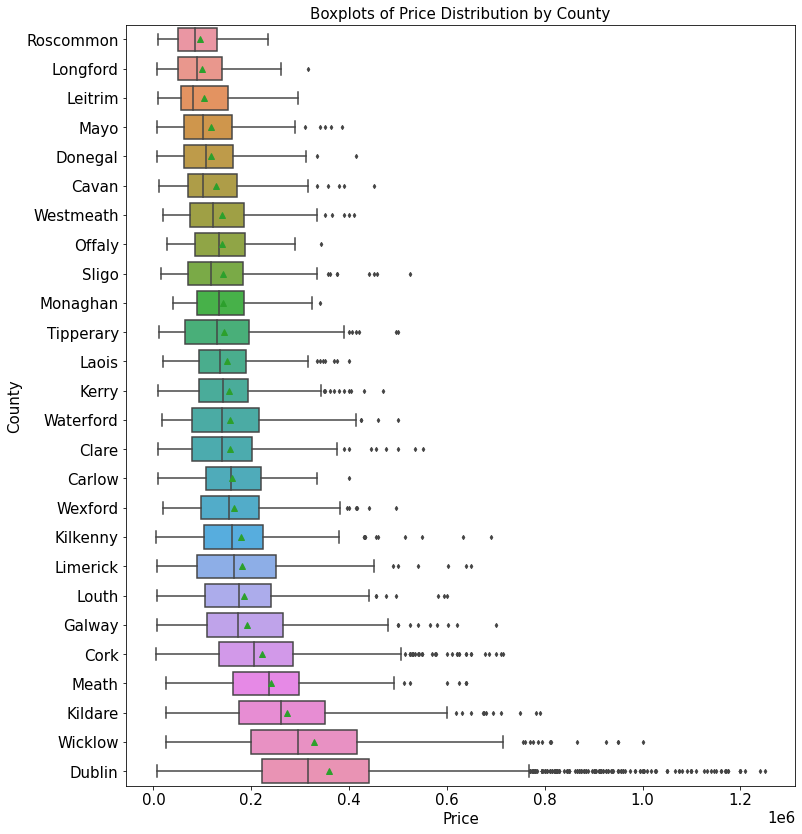

In [127]:
fig, ax = plt.subplots(figsize=(12,14))
means = copy_clean_df_updated['Price(€)'].groupby(copy_clean_df_updated["County"]).mean().sort_values().index
sns.set_context(rc={"font.size":15, "axes.titlesize":15, "axes.labelsize":15})
sns.boxplot(x = copy_clean_df_updated['Price(€)'], y=copy_clean_df_updated['County'], fliersize = 3, showmeans = True, order=means)
plt.xlabel('Price')

plt.title('Boxplots of Price Distribution by County')
plt.show()

In [128]:
print("\n Reminder of coefficients in original Linear Regression model")
linreg_display_df.sort_values('Coefficient', ascending=False)


 Reminder of coefficients in original Linear Regression model


,Feature,Coefficient
41,PostalCode_Dublin 4,317546.510801
44,PostalCode_Dublin 6w,282733.377066
43,PostalCode_Dublin 6,279439.951395
31,PostalCode_Dublin 14,265373.683130
6,County_Dublin,216078.953006
33,PostalCode_Dublin 16,182254.183883
26,County_Wicklow,180704.133505
35,PostalCode_Dublin 18,163931.551800
40,PostalCode_Dublin 3,147738.321448
9,County_Kildare,113336.654895


From the above it is clear that 5 counties in particular, Dublin, Wicklow, Kildare, Meath and Cork, all have distributions that are quite different to the rest of the dataset. So as to maintain some level of regional information, I will create a new column with these 5 columns, and assign each of the remaining to a category based on their province.

In [129]:
# lists of provinces
connacht = ['Galway', 'Mayo', 'Sligo', 'Roscommon', 'Leitrim']
munsterExCork = ['Kerry', 'Waterford', 'Tipperary', 'Clare', 'Limerick']
ulster = ['Cavan', 'Monaghan', 'Donegal']
leinsterExDubMeathWickKild = ['Westmeath', 'Wexford', 'Offaly','Kilkenny','Carlow', 'Louth', 'Longford', 'Laois']

In [130]:
# assign rows to correct category
for index, row in copy_clean_df_updated.iterrows():
    if row['County'] == 'Dublin':
        copy_clean_df_updated.loc[index, 'Region'] = "Dublin"
    elif row['County'] == 'Meath':
        copy_clean_df_updated.loc[index, 'Region'] = "Meath"
    elif row['County'] == 'Kildare':
        copy_clean_df_updated.loc[index, 'Region'] = "Kildare"
    elif row['County'] == 'Wicklow':
        copy_clean_df_updated.loc[index, 'Region'] = "Wicklow"
    elif row['County'] == 'Cork':
        copy_clean_df_updated.loc[index, 'Region'] = "Cork"
    elif row['County'] in connacht:
        copy_clean_df_updated.loc[index, 'Region'] = "Connacht"
    elif row['County'] in munsterExCork:
        copy_clean_df_updated.loc[index, 'Region'] = "MunsterExCork"
    elif row['County'] in ulster:
        copy_clean_df_updated.loc[index, 'Region'] = "Ulster"
    elif row['County'] in leinsterExDubMeathWickKild:
        copy_clean_df_updated.loc[index, 'Region'] = "ExDubMeathWickKild"

        
# make Region a category
copy_clean_df_updated['Region'] = copy_clean_df_updated['Region'].astype('category')

In [131]:
regionDummies = pd.get_dummies(copy_clean_df_updated['Region'], prefix='Region', drop_first=True)
copy_clean_df_updated = pd.concat([copy_clean_df_updated, regionDummies], axis=1)

I will now do the same for the Postal Codes.

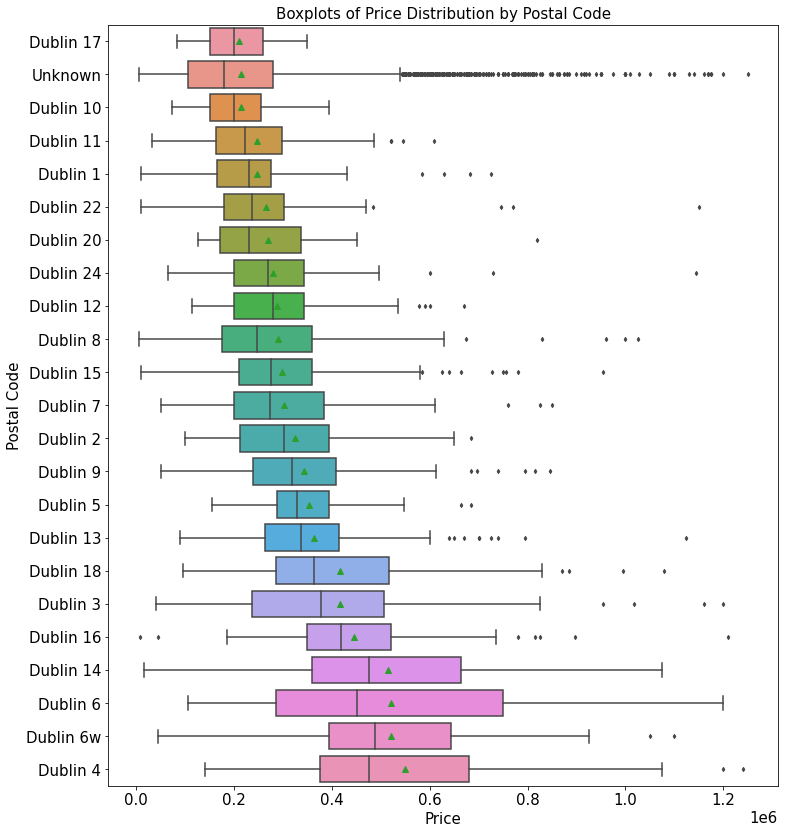

In [132]:
fig, ax = plt.subplots(figsize=(12,14))
means = copy_clean_df_updated['Price(€)'].groupby(copy_clean_df_updated["PostalCode"]).mean().sort_values().index
sns.set_context(rc={"font.size":15, "axes.titlesize":15, "axes.labelsize":15})
sns.boxplot(x = copy_clean_df_updated['Price(€)'], y=copy_clean_df_updated['PostalCode'], fliersize = 3, showmeans = True, order=means)
plt.xlabel('Price')
plt.ylabel('Postal Code')
plt.title('Boxplots of Price Distribution by Postal Code')
plt.show()

In [133]:
# postal codes are only for Dublin properties
copy_clean_df_updated['PostalCode'].value_counts(dropna=False)

Unknown      7410
Dublin 15     242
Dublin 24     161
Dublin 18     136
Dublin 13     114
Dublin 8      113
Dublin 11     112
Dublin 12     105
Dublin 4      102
Dublin 14     100
Dublin 9      100
Dublin 7       99
Dublin 16      96
Dublin 3       87
Dublin 1       72
Dublin 6       69
Dublin 22      68
Dublin 5       56
Dublin 2       35
Dublin 6w      32
Dublin 20      23
Dublin 10      17
Dublin 17      17
Name: PostalCode, dtype: int64

There is significant scope for combinations here. 

- Unknown will need to stay as it was before now. 
- Dublin 4 is big enough and impactful enough to stay as its own category. 
- Dublin 6w has few entries, is geographically close to Dublin 6, and close in price distribution. I will combine these categories as 'Dublin6Full'.
- Dublin 14, 16, and 18 are all close geographically and in price. I will combine these as 'SouthDublinExpensive'.
- Dublin 3, 13, 5, 9, 7 and 15 are also all close geographically and in price. I will combine these as 'NorthDublinExpensive'
- I will therefore combine Dublin 2, 8, 12, 24, 20, 22 and 10 as 'SouthDublinCheaper'.
- I will also combine Dublin 1, 11 and 17 as 'NorthDublinCheaper'.

In [134]:
Dublin6All = ['Dublin 6', 'Dublin 6w']
SouthDublinExpensive = ['Dublin 14', 'Dublin 16', 'Dublin 18']
NorthDublinExpensive = ['Dublin 3', 'Dublin 13', 'Dublin 5', 'Dublin 9', 'Dublin 7', 'Dublin 15']
SouthDublinCheaper = ['Dublin 2', 'Dublin 8', 'Dublin 12', 'Dublin 24', 'Dublin 20', 'Dublin 22', 'Dublin 10']
NorthDublinCheaper = ['Dublin 1', 'Dublin 11', 'Dublin 17']

In [135]:
# assign rows to correct category
for index, row in copy_clean_df_updated.iterrows():
    if row['PostalCode'] == 'Dublin 4':
        copy_clean_df_updated.loc[index, 'PostalCombined'] = "Dublin 4"
    elif row['PostalCode'] == 'Unknown':
        copy_clean_df_updated.loc[index, 'PostalCombined'] = "Unknown"
    elif row['PostalCode'] in Dublin6All:
        copy_clean_df_updated.loc[index, 'PostalCombined'] = "Dublin6All"
    elif row['PostalCode'] in SouthDublinExpensive:
        copy_clean_df_updated.loc[index, 'PostalCombined'] = "SouthDublinExpensive"
    elif row['PostalCode'] in NorthDublinExpensive:
        copy_clean_df_updated.loc[index, 'PostalCombined'] = "NorthDublinExpensive"
    elif row['PostalCode'] in SouthDublinCheaper:
        copy_clean_df_updated.loc[index, 'PostalCombined'] = "SouthDublinCheaper"
    elif row['PostalCode'] in NorthDublinCheaper:
        copy_clean_df_updated.loc[index, 'PostalCombined'] = "NorthDublinCheaper"
    
# make PostalCombined a category
copy_clean_df_updated['PostalCombined'] = copy_clean_df_updated['PostalCombined'].astype('category')

In [136]:
postalCombinedDummies = pd.get_dummies(copy_clean_df_updated['PostalCombined'], prefix='PostalCombined', drop_first=True)
copy_clean_df_updated = pd.concat([copy_clean_df_updated, postalCombinedDummies], axis=1)

In [137]:
# drop county and postal code
copy_clean_df_updated = copy_clean_df_updated.drop(columns=['County', 'PostalCode', 'Region', 'PostalCombined'])

The Postal Codes and Counties have now been grouped together as appropriate and encoded. I will now model them using linear regression.

In [138]:
updatedTrain, updatedTest = train_test_split(copy_clean_df_updated, test_size=0.3, random_state=0)

In [139]:
# set a list of all column names except for Price(€) and DateofSale
predictionsUpdated = [feature for feature in list(updatedTrain.columns) if (feature != 'Price(€)' and feature != 'DateofSale(yyyy-mm-dd)')]

In [140]:
# fit the linear model
linregUpdated = LinearRegression().fit(updatedTrain[predictionsUpdated], updatedTrain[target])
updated_linreg_display_df = pd.DataFrame()
updated_linreg_display_df['Feature'] = predictionsUpdated
updated_linreg_display_df['Coefficient'] = linregUpdated.coef_
intercept = linregUpdated.intercept_
print("Intercept:", intercept)
print("\n Features & their coefficients")
updated_linreg_display_df.sort_values('Coefficient', ascending=False)

Intercept: 280710.95746847166

 Features & their coefficients


,Feature,Coefficient
3,Region_Dublin,211744.855571
9,Region_Wicklow,176227.061895
5,Region_Kildare,109082.984053
6,Region_Meath,73651.284196
2,Region_Cork,68448.810558
0,DescriptionofProperty,46790.746813
7,Region_MunsterExCork,5170.714925
4,Region_ExDubMeathWickKild,3112.692741
1,quarter,2818.479281
8,Region_Ulster,-29920.990652


The above coefficients look very intuitive. It is clear that those regions and postal codes as identified as cheap and expensive above have coefficients corresponding to this.

In [141]:
# use the model to predict values for training set
predictedLinRegTrainUpdated = linregUpdated.predict(updatedTrain[predictionsUpdated])

In [142]:
predictorsUpdated = updatedTrain[predictionsUpdated].shape[1]
print("\u0332".join("Regression Evaluation Measures for Training Set"))
RegressionMetrics(updatedTrain[target], predictedLinRegTrainUpdated, predictorsUpdated, updatedTrain.shape[0])

R̲e̲g̲r̲e̲s̲s̲i̲o̲n̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲a̲s̲u̲r̲e̲s̲ ̲f̲o̲r̲ ̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲S̲e̲t
MAE: 94747.31344130571
RMSE: 133678.21133844912
R2: 0.39806613225682064
Adjusted R2: 0.3965932859678023


In [143]:
predictedTestUpdated = linregUpdated.predict(updatedTest[predictionsUpdated])

In [144]:
RegressionMetrics(updatedTest[target], predictedTestUpdated, predictorsUpdated, updatedTest.shape[0])

MAE: 95004.95233545273
RMSE: 132533.33998783017
R2: 0.3751741817981362
Adjusted R2: 0.3715948000970156


In [145]:
# merging entire dataset
entire_dataset_updated = pd.concat([updatedTrain, updatedTest]).reset_index(drop=True)

# conducting cross validation
kfoldUpdated = cross_validate(LinearRegression(), entire_dataset_updated[predictionsUpdated], entire_dataset_updated[target], scoring=testMetrics, cv=10)

In [146]:
df_cross_validate_updated = pd.DataFrame()
df_cross_validate_updated['Fold'] = [x for x in range(1,11)]
df_cross_validate_updated['MAE'] = -kfoldUpdated['test_neg_mean_absolute_error']
df_cross_validate_updated['RMSE'] = -kfoldUpdated['test_neg_mean_squared_error']
df_cross_validate_updated['RMSE'] = df_cross_validate_updated['RMSE'].apply(lambda val: math.sqrt(val))
df_cross_validate_updated['R2'] = kfoldUpdated['test_r2']

ave_row_lin_reg_updated = {'Fold':'Average', 'MAE':df_cross_validate_updated['MAE'].mean(), 'RMSE':df_cross_validate_updated['RMSE'].mean(),
           'R2':df_cross_validate_updated['R2'].mean()}

df_cross_validate_updated = df_cross_validate_updated.append(ave_row_lin_reg_updated, ignore_index=True)
df_cross_validate_updated =df_cross_validate_updated.style.apply(highlight_last)

df_cross_validate_updated

,Fold,MAE,RMSE,R2
0,1,94672.605675,130755.040240,0.380869
1,2,93507.131653,137816.798389,0.380428
2,3,96680.035429,137365.802011,0.385895
3,4,95152.714532,133744.030373,0.390572
4,5,98658.508991,136167.870913,0.400230
5,6,94383.587767,134114.353450,0.406802
6,7,93195.497409,128363.208757,0.414690
7,8,95715.236658,137998.579473,0.371677
8,9,97023.809585,137921.899894,0.359942
9,10,92600.842667,120730.164792,0.399860


- Unfortunately this actually made the model very slightly worse. This implies that the model benefitted from the greater detail.
- Across all measures in the training and testing evaluation measures, they are very marginally worse. Clearly therefore, it is not worth including this.

I will now out of interest use this dataset on the Random Forest Regression model to see if its results are improved through using it.

In [147]:
# initialise the RandomForestRegressor
# set random state value so that results can be replicated
forestRegUpdated = RandomForestRegressor(n_estimators=100, max_depth=10, max_features='auto', oob_score=True, random_state=1)

# fit the model on the training set using the predictions features
forestRegUpdated.fit(updatedTrain[predictionsUpdated], updatedTrain[target])

RandomForestRegressor(max_depth=10, oob_score=True, random_state=1)

In [148]:
feature_importance = pd.DataFrame({'feature': updatedTrain[predictionsUpdated].columns, 'importance':forestRegUpdated.feature_importances_})
print("\u0332".join("Feature Importance Random Forest Regressor"))
feature_importance.sort_values('importance', ascending=False)

F̲e̲a̲t̲u̲r̲e̲ ̲I̲m̲p̲o̲r̲t̲a̲n̲c̲e̲ ̲R̲a̲n̲d̲o̲m̲ ̲F̲o̲r̲e̲s̲t̲ ̲R̲e̲g̲r̲e̲s̲s̲o̲r


,feature,importance
3,Region_Dublin,0.413894
1,quarter,0.284153
0,DescriptionofProperty,0.051568
9,Region_Wicklow,0.048362
5,Region_Kildare,0.026992
12,PostalCombined_NorthDublinExpensive,0.024969
13,PostalCombined_SouthDublinCheaper,0.023973
11,PostalCombined_NorthDublinCheaper,0.022144
15,PostalCombined_Unknown,0.022133
2,Region_Cork,0.021978


In [149]:
# predict entire training dataset using random forest regressor model
forestRegPredictedTrainUpdated = forestRegUpdated.predict(updatedTrain[predictionsUpdated])

In [150]:
print("\u0332".join("Regression Evaluation Measures for Training Set"))
RegressionMetrics(updatedTrain[target], forestRegPredictedTrainUpdated, predictorsUpdated, updatedTrain.shape[0])

R̲e̲g̲r̲e̲s̲s̲i̲o̲n̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲a̲s̲u̲r̲e̲s̲ ̲f̲o̲r̲ ̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲S̲e̲t
MAE: 86108.57331305118
RMSE: 121787.88398646413
R2: 0.5003847369551477
Adjusted R2: 0.49916224969276546


In [151]:
# predict entire test dataset using random forest regressor model
forestRegPredictedTestUpdated = forestRegUpdated.predict(updatedTest[predictionsUpdated])
print("\u0332".join("Regression Evaluation Measures for Test Set"))
RegressionMetrics(updatedTest[target], forestRegPredictedTestUpdated, predictorsUpdated, updatedTest.shape[0])

R̲e̲g̲r̲e̲s̲s̲i̲o̲n̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲a̲s̲u̲r̲e̲s̲ ̲f̲o̲r̲ ̲T̲e̲s̲t̲ ̲S̲e̲t
MAE: 94886.12283177499
RMSE: 132595.9945212837
R2: 0.3745832750316971
Adjusted R2: 0.3710005082578006


- As with the linear regression model, once again the decreased granularity in the Postal Codes and Counties has marginally reduced the model accuracy.
- This is unfortunate, and means that I will proceed with the original method of encoding each one individually.

<b>Improvement #2: Implementing Lagged Stock Prices</b>

I had previously introduced stock prices in Homework 1, but dismissed them at the beginning due to their significant correlation with the Date. However, I feel this may have been rash, and some sort of ability to mimic the trends in the macro economy may help with modelling. This time however I will use 6 month lagged stock prices.

I first need to encode the Postal Codes and Counties as this has not been done to the main dataframe yet.

In [152]:
countyDummies = pd.get_dummies(clean_df_updated['County'], prefix='County', drop_first=True)
clean_df_updated = pd.concat([clean_df_updated, countyDummies], axis=1)

In [153]:
postalDummies = pd.get_dummies(clean_df_updated['PostalCode'], prefix='PostalCode', drop_first=True)
clean_df_updated = pd.concat([clean_df_updated, postalDummies], axis=1)
clean_df_updated = clean_df_updated.drop(columns=['PostalCode'])

In [154]:
# make a copy of the dataframe as we do not know if the changes made will be beneficial
copy_clean_df_updated_stock = clean_df_updated.copy()

Prices from https://finance.yahoo.com/quote/%5ESTOXX50E/history?period1=1230768000&period2=1651363200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [155]:
# read in the csv of prices
eurostoxx = pd.read_csv('datasets/eurostoxxhistorical.csv')
eurostoxx.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-01-05,2551.699951,2563.959961,2527.330078,2553.409912,2553.409912,0.0
1,2009-01-06,2558.340088,2608.149902,2542.689941,2578.429932,2578.429932,0.0
2,2009-01-07,2570.870117,2572.070068,2520.610107,2538.550049,2538.550049,0.0
3,2009-01-08,2516.860107,2532.050049,2481.669922,2516.560059,2516.560059,0.0
4,2009-01-09,2524.739990,2543.830078,2466.139893,2486.590088,2486.590088,0.0
5,2009-01-12,2482.790039,2491.090088,2447.590088,2451.870117,2451.870117,0.0
6,2009-01-13,2445.040039,2445.040039,2385.040039,2411.280029,2411.280029,0.0
7,2009-01-14,2420.429932,2426.290039,2274.620117,2298.459961,2298.459961,0.0
8,2009-01-15,2300.830078,2312.830078,2235.300049,2257.669922,2257.669922,0.0
9,2009-01-16,2281.790039,2343.110107,2278.199951,2281.449951,2281.449951,0.0


In [156]:
# drop unnecessary cols
eurostoxx = eurostoxx.drop(eurostoxx.columns[[1,2,3,5,6]], axis=1)

In [157]:
# set Date to datetime pandas datatype
eurostoxx['Date'] = pd.to_datetime(eurostoxx['Date'])

In [158]:
# add 6 months to date
eurostoxx['Date'] = eurostoxx['Date'] + pd.Timedelta(days=6*30)

In [159]:
# set date as index
eurostoxx.set_index('Date', inplace=True)

# Resampling + filling missing values
eurostoxx = eurostoxx.resample('1D').pad()

In [160]:
# merge the two datasets by the date columns
copy_clean_df_updated_stock = copy_clean_df_updated_stock.merge(eurostoxx, left_on=['DateofSale(yyyy-mm-dd)'],right_on=['Date'], how='left')
# rename the column
copy_clean_df_updated_stock = copy_clean_df_updated_stock.rename(columns={'Close': 'StockPrice'})

In [161]:
# remove infinite values
copy_clean_df_updated_stock['StockPrice'].replace([np.inf, -np.inf], np.nan, inplace=True)
# setting copy_clean_df_updated_stock to equal only those rows that are populated with a price
copy_clean_df_updated_stock = copy_clean_df_updated_stock[copy_clean_df_updated_stock['StockPrice'].notna()]

The 6 month lagged stock price has now been added. I will now split the model into training and testing include this in the linear model. 

In [162]:
trainStock, testStock = train_test_split(copy_clean_df_updated_stock, test_size=0.3, random_state=0)

In [163]:
# set a list of all column names except for Price(€), County and DateofSale
predictionsStocks = [feature for feature in list(trainStock.columns) if (feature != 'Price(€)' and feature != 'DateofSale(yyyy-mm-dd)' and feature != 'County')]

In [164]:
# fit the linear model
linregStock = LinearRegression().fit(trainStock[predictionsStocks], trainStock[target])
updated_linreg_display_df = pd.DataFrame()
updated_linreg_display_df['Feature'] = predictionsStocks
updated_linreg_display_df['Coefficient'] = linregStock.coef_
intercept = linregStock.intercept_
print("Intercept:", intercept)
print("\n Features & their coefficients")
updated_linreg_display_df.sort_values('Coefficient', ascending=False)

Intercept: -100524.33344329995

 Features & their coefficients


,Feature,Coefficient
41,PostalCode_Dublin 4,303598.285268
43,PostalCode_Dublin 6,299028.428640
31,PostalCode_Dublin 14,271728.878383
44,PostalCode_Dublin 6w,263557.007562
6,County_Dublin,221610.061501
26,County_Wicklow,184871.493002
33,PostalCode_Dublin 16,181171.619185
35,PostalCode_Dublin 18,171956.827308
40,PostalCode_Dublin 3,155701.042797
9,County_Kildare,125046.612732


Can now see that StockPrice has a coefficient of 16.6. This sounds small but given that it is a continuous feature with values that are quite high it may have a significant impact on price predictions.

In [165]:
# use the model to predict values for training set
predictedLinRegTrainStock = linregStock.predict(trainStock[predictionsStocks])

In [166]:
predictorsStock = trainStock[predictionsStocks].shape[1]
print("\u0332".join("Regression Evaluation Measures for Training Set"))
RegressionMetrics(trainStock[target], predictedLinRegTrainStock, predictorsStock, trainStock.shape[0])

R̲e̲g̲r̲e̲s̲s̲i̲o̲n̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲a̲s̲u̲r̲e̲s̲ ̲f̲o̲r̲ ̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲S̲e̲t
MAE: 92090.5697010295
RMSE: 129071.3671521135
R2: 0.4193428112314975
Adjusted R2: 0.41487827802552724


In [167]:
predictedLinRegTestStock = linregStock.predict(testStock[predictionsStocks])

In [168]:
print("\u0332".join("Regression Evaluation Measures for Test Set"))
RegressionMetrics(testStock[target], predictedLinRegTestStock, predictorsStock, testStock.shape[0])

R̲e̲g̲r̲e̲s̲s̲i̲o̲n̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲a̲s̲u̲r̲e̲s̲ ̲f̲o̲r̲ ̲T̲e̲s̲t̲ ̲S̲e̲t
MAE: 95703.81591883695
RMSE: 136830.63217127058
R2: 0.3837225410783839
Adjusted R2: 0.3725499983133075


In [169]:
# merging entire dataset
entire_dataset_stock = pd.concat([trainStock, testStock]).reset_index(drop=True)

# conducting cross validation
kfoldStock = cross_validate(LinearRegression(), entire_dataset_stock[predictionsStocks], entire_dataset_stock[target], scoring=testMetrics, cv=10)

In [170]:
df_cross_validate_stock = pd.DataFrame()
df_cross_validate_stock['Fold'] = [x for x in range(1,11)]
df_cross_validate_stock['MAE'] = -kfoldStock['test_neg_mean_absolute_error']
df_cross_validate_stock['RMSE'] = -kfoldStock['test_neg_mean_squared_error']
df_cross_validate_stock['RMSE'] = df_cross_validate_stock['RMSE'].apply(lambda val: math.sqrt(val))
df_cross_validate_stock['R2'] = kfoldStock['test_r2']

ave_row_lin_reg_stock = {'Fold':'Average', 'MAE':df_cross_validate_stock['MAE'].mean(), 'RMSE':df_cross_validate_stock['RMSE'].mean(),
           'R2':df_cross_validate_stock['R2'].mean()}

df_cross_validate_stock = df_cross_validate_stock.append(ave_row_lin_reg_stock, ignore_index=True)
df_cross_validate_stock =df_cross_validate_stock.style.apply(highlight_last)

df_cross_validate_stock

,Fold,MAE,RMSE,R2
0,1,90038.681065,124704.445209,0.392176
1,2,95396.741514,134194.453413,0.367275
2,3,92345.098423,127464.582219,0.443014
3,4,94524.932626,134394.444337,0.394486
4,5,94263.085986,133266.580905,0.415713
5,6,89364.433767,125486.319371,0.437594
6,7,92891.478827,129753.765416,0.425575
7,8,95087.730876,142116.802054,0.379726
8,9,96181.776291,134117.485331,0.401494
9,10,95536.954183,133904.551627,0.370921


Once again it is unfortunate to see that including the stock price did not make a notable change to the accuracy of predictions. There is a slight uptick in the performance of the predictions of the training set, however in the test set it drops to a point where the results are almost indistinguishable. Given that this is more computationally intensive and has increased complexity I will not include this feature going forward. The model is able to perform just as well without the extra noise.

It is interesting to note that my earlier rationalie to drop the stock price given its high correlation with the date seems to have proven to be the correct decision.

<b>Improvement #3: Removing Price outliers below the mean</b>

As mentioned above, in Homework 1 I removed outliers above the mean, without consideration for those below. I will now remove those Prices below the mean in the same way. 

In [171]:
# set a log price column from the Price(€) column
clean_df_updated['logPrice'] = clean_df_updated['Price(€)'].apply(lambda row: np.log(row))
clean_df_updated['logPrice'] = clean_df_updated['logPrice'].astype(float)

In [172]:
# create a list of all counties
allcounties = clean_df_updated['County'].unique().tolist()

# initialise counter to see how many prices removed
pricecounter = 0
# loop through county list
for county in allcounties:
    # create a new dataframe for county
    subdataframe = clean_df_updated[clean_df_updated['County'].isin([county])]
    # iterate through this dataframe
    for index, row in subdataframe.iterrows():
        # check if log price is lower than 2 standard deviations from the mean
        if row['logPrice'] < (subdataframe["logPrice"].mean() - 2*subdataframe["logPrice"].std()):
            # apply change to dfclean, not new dataframe
            clean_df_updated.loc[index,'logPrice'] = np.nan
            pricecounter += 1

# set Price(€) to exponent of what is left of logPrice column
clean_df_updated['Price(€)'] = clean_df_updated['logPrice'].apply(lambda row: np.exp(row))

# no need for logPrice column any more
clean_df_updated.drop('logPrice', axis=1, inplace=True)

print(pricecounter, "prices of outliers removed from price column.")

# drop rows without a Price(€)
clean_df_updated = clean_df_updated.dropna(subset=['Price(€)'])

324 prices of outliers removed from price column.


No need to keep County column anymore

In [173]:
clean_df_updated = clean_df_updated.drop(columns=['County'])

In [174]:
trainLower, testLower = train_test_split(clean_df_updated, test_size=0.3, random_state=0)

In [175]:
# set a list of all column names except for Price(€), and DateofSale
predictionsLower = [feature for feature in list(trainLower.columns) if (feature != 'Price(€)' and feature != 'DateofSale(yyyy-mm-dd)')]

In [176]:
# fit the linear model
linregLower = LinearRegression().fit(trainLower[predictionsLower], trainLower[target])
updated_linreg_display_df = pd.DataFrame()
updated_linreg_display_df['Feature'] = predictionsLower
updated_linreg_display_df['Coefficient'] = linregLower.coef_
intercept = linregLower.intercept_
print("Intercept:", intercept)
print("\n Features & their coefficients")
updated_linreg_display_df.sort_values('Coefficient', ascending=False)

Intercept: -29543.82349869056

 Features & their coefficients


,Feature,Coefficient
43,PostalCode_Dublin 6,301025.396895
41,PostalCode_Dublin 4,285029.733920
31,PostalCode_Dublin 14,260751.717085
44,PostalCode_Dublin 6w,235305.101348
6,County_Dublin,217939.981577
33,PostalCode_Dublin 16,195477.568620
26,County_Wicklow,182094.393216
40,PostalCode_Dublin 3,149392.882463
35,PostalCode_Dublin 18,133223.436904
9,County_Kildare,114461.908438


In [177]:
# use the model to predict values for training set
predictedLinRegTrainLower = linregLower.predict(trainLower[predictionsLower])

In [178]:
predictorsLower = trainLower[predictionsLower].shape[1]
print("\u0332".join("Regression Evaluation Measures for Training Set"))
RegressionMetrics(trainLower[target], predictedLinRegTrainLower, predictorsLower, trainLower.shape[0])

R̲e̲g̲r̲e̲s̲s̲i̲o̲n̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲a̲s̲u̲r̲e̲s̲ ̲f̲o̲r̲ ̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲S̲e̲t
MAE: 91550.24481818781
RMSE: 129781.43721080582
R2: 0.426953799214962
Adjusted R2: 0.4224818667673641


In [179]:
predictedLinRegTestLower = linregLower.predict(testLower[predictionsLower])

In [180]:
print("\u0332".join("Regression Evaluation Measures for Test Set"))
RegressionMetrics(testLower[target], predictedLinRegTestLower, predictorsLower, testLower.shape[0])

R̲e̲g̲r̲e̲s̲s̲i̲o̲n̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲a̲s̲u̲r̲e̲s̲ ̲f̲o̲r̲ ̲T̲e̲s̲t̲ ̲S̲e̲t
MAE: 90769.44404043982
RMSE: 128007.21803107527
R2: 0.3945960052780091
Adjusted R2: 0.383456389903853


In [181]:
# merging entire dataset
entire_dataset_lower = pd.concat([trainLower, testLower]).reset_index(drop=True)

# conducting cross validation
kfoldLower = cross_validate(LinearRegression(), entire_dataset_lower[predictionsLower], entire_dataset_lower[target], scoring=testMetrics, cv=10)

In [182]:
df_cross_validate_lower = pd.DataFrame()
df_cross_validate_lower['Fold'] = [x for x in range(1,11)]
df_cross_validate_lower['MAE'] = -kfoldLower['test_neg_mean_absolute_error']
df_cross_validate_lower['RMSE'] = -kfoldLower['test_neg_mean_squared_error']
df_cross_validate_lower['RMSE'] = df_cross_validate_lower['RMSE'].apply(lambda val: math.sqrt(val))
df_cross_validate_lower['R2'] = kfoldLower['test_r2']

ave_row_lin_reg_lower = {'Fold':'Average', 'MAE':df_cross_validate_lower['MAE'].mean(), 'RMSE':df_cross_validate_lower['RMSE'].mean(),
           'R2':df_cross_validate_lower['R2'].mean()}

df_cross_validate_lower = df_cross_validate_lower.append(ave_row_lin_reg_lower, ignore_index=True)
df_cross_validate_lower =df_cross_validate_lower.style.apply(highlight_last)

df_cross_validate_lower

,Fold,MAE,RMSE,R2
0,1,88758.908480,122383.613251,0.411334
1,2,92032.562037,130040.851751,0.414724
2,3,91327.471180,131602.805571,0.397212
3,4,90045.794769,126810.561728,0.453270
4,5,97762.246212,138796.066464,0.426605
5,6,89932.032506,121466.062074,0.464164
6,7,95576.561982,141529.695089,0.374585
7,8,93289.586263,131076.195326,0.370148
8,9,87668.116162,125293.937673,0.411321
9,10,91306.948055,127007.008921,0.407878


- Unsurprisingly this has improved the model, but only to a very small extent.
- The R<sup>2</sup> value is higher for the training, testing and cross validations, and I note slight decreases in the MAE and RMSE value.
- This is not surprising as I have removed values that were outliers, and thus hard to model.
- This is a step that probably should have been conducted earlier, although it is good to see that this has indeed increased the performance of the Linear Regression model.

<b>Summary of Improvements</b>

- In hindsight it is probably not overly surprising that combining features together did not improve the model. Having observed similar trends in various groupings I made I had expected to increase model performance, however it is a good lesson to learn that removing data is not always for the best.
- Removing further outliers improved the model to a slight extent. This is not surprising. Having a distribution now more centred around the mean is very likely to be easier to predict. It does ask the question however as to how fair it is to remove data like this. However, given this information is on the peripherary of the dataset, and not 'like' the rest of the data, it is never going to be predicted accurately in any realistic model that has some degree of error.
- As seen, access to more granular information on the specifics of the property such as property size, even information that was not overly specific, helped to improve the accuracy of the model. Obtaining this type of information for every property would surely result in a significantly more robust predictions.

I will now update the main model with the new coefficients found so that it can be used in the next section.

In [183]:
# updating linreg
linreg = LinearRegression().fit(trainLower[predictionsLower], trainLower[target])

### 5.3 Evaluating Model on new Test Data

Next I will evaluate my Linear Regression model on the '22032022-PPR-Price-recent.csv' dataset. I will first need to transform this dataset in the same way the original dataset was transformed (although steps completed for the columns that have been removed can obviously be ignored).

In [184]:
# read in new dataset
newTestDF = pd.read_csv('datasets/22032022-PPR-Price-recent.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)

In [185]:
# number of rows & cols
print("This dataset has", newTestDF.shape[0], "rows and", newTestDF.shape[1], "columns")

This dataset has 7182 rows and 9 columns


In [186]:
# print first 5 rows
print("First 5 rows")
newTestDF.head()

First 5 rows


,DateofSale(dd/mm/yyyy),Address,PostalCode,County,Price(€),NotFullMarketPrice,VATExclusive,DescriptionofProperty,PropertySizeDescription
0,2022-01-15,"24 FOREST WALK, SWORDS, DUBLIN",NaN,Dublin,154000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
1,2022-01-15,"5 CRAGAUN, FATHER RUSSELL ROAD, DOORADOYLE",NaN,Limerick,370000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
2,2022-01-16,"19 The Lawn, Mullen Park, Maynooth",NaN,Kildare,409691.63,No,Yes,New Dwelling house /Apartment,NaN
3,2022-01-16,"MONTEVIDEO, HOSPITAL HILL, BUNCLODY",NaN,Wexford,100000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
4,2022-01-17,"1 CILL BEG MANOR, STRADBALLY, LAOIS",NaN,Laois,225000.00,No,No,Second-Hand Dwelling house /Apartment,NaN


In [187]:
# converting to datetime and specifying the day comes first in original data
newTestDF['DateofSale(dd/mm/yyyy)'] = pd.to_datetime(newTestDF['DateofSale(dd/mm/yyyy)'], dayfirst=True)
newTestDF.rename(columns={'DateofSale(dd/mm/yyyy)':'DateofSale(yyyy-mm-dd)'},inplace=True)
newTestDF['DateofSale(yyyy-mm-dd)'] = newTestDF['DateofSale(yyyy-mm-dd)'].astype('datetime64[ns]')

In [188]:
# check datatypes
newTestDF.dtypes

DateofSale(yyyy-mm-dd)     datetime64[ns]
Address                            object
PostalCode                         object
County                             object
Price(€)                          float64
NotFullMarketPrice                 object
VATExclusive                       object
DescriptionofProperty              object
PropertySizeDescription           float64
dtype: object

In [189]:
newTestDF.describe(include="all").T

/var/folders/sk/nrbzmqq1715frfmf08t0c02c0000gn/T/ipykernel_31918/1801416788.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  newTestDF.describe(include="all").T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
DateofSale(yyyy-mm-dd),7182,52,2022-01-28 00:00:00,350,2022-01-15,2022-03-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Address,7182,7145,"APT 1, 21 MARY STREET LITTLE, DUBLIN 7",4,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,1507,21,Dublin 15,207,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
County,7182,26,Dublin,2217,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price(€),7182.0,NaN,NaN,NaN,NaT,NaT,341755.395959,564033.780437,7000.0,186000.0,273128.5,385523.0,30566192.72
NotFullMarketPrice,7182,2,No,6953,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VATExclusive,7182,2,No,6197,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DescriptionofProperty,7182,2,Second-Hand Dwelling house /Apartment,6182,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PropertySizeDescription,0.0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [190]:
# convert all of the addresses to lower case
newTestDF["Address"] = newTestDF["Address"].str.lower()

In [191]:
print('Number of duplicate (excluding first) rows in the dataframe is: ', newTestDF.duplicated().sum())

Number of duplicate (excluding first) rows in the dataframe is:  18


In [192]:
duplicatedRows=newTestDF[newTestDF.duplicated(keep=False)]
duplicatedRows

,DateofSale(yyyy-mm-dd),Address,PostalCode,County,Price(€),NotFullMarketPrice,VATExclusive,DescriptionofProperty,PropertySizeDescription
809,2022-01-20,"knockbrogan, bandon",NaN,Cork,145000.00,No,No,New Dwelling house /Apartment,NaN
810,2022-01-20,"knockbrogan, bandon",NaN,Cork,145000.00,No,No,New Dwelling house /Apartment,NaN
1623,2022-01-26,"the square, barrack street, tallow",NaN,Waterford,54000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
1624,2022-01-26,"the square, barrack street, tallow",NaN,Waterford,54000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
1727,2022-01-27,"46 broughton st, dundalk, louth",NaN,Louth,235000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
1728,2022-01-27,"46 broughton st, dundalk, louth",NaN,Louth,235000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
1901,2022-01-28,"18 stapolin avenue, the coast, baldoyle",NaN,Dublin,440528.63,No,Yes,New Dwelling house /Apartment,NaN
1902,2022-01-28,"18 stapolin avenue, the coast, baldoyle",NaN,Dublin,440528.63,No,Yes,New Dwelling house /Apartment,NaN
3303,2022-02-07,"bushcormer, priest newtown, delgany",NaN,Wicklow,25000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
3304,2022-02-07,"bushcormer, priest newtown, delgany",NaN,Wicklow,25000.00,No,No,Second-Hand Dwelling house /Apartment,NaN


Although the aim is prediction of the entire dataset provided, clearly it makes sense to remove the duplicates. Predicting the same price twice could impact the evaluation measures quite negatively, particularly if the duplicate is an outlier. I will now remove the duplicates.

In [193]:
initial = newTestDF.shape[0]
newTestDF.drop_duplicates(inplace=True)
after = newTestDF.shape[0]
print(initial-after, "duplicated rows were deleted.")

18 duplicated rows were deleted.


In [194]:
# postal codes are only for Dublin properties
newTestDF['PostalCode'].value_counts(dropna=False)

NaN          5660
Dublin 15     207
Dublin 3      141
Dublin 16     114
Dublin 18     100
Dublin 24      98
Dublin 9       85
Dublin 8       84
Dublin 13      83
Dublin 4       74
Dublin 12      69
Dublin 7       67
Dublin 22      61
Dublin 14      61
Dublin 11      60
Dublin 6       55
Dublin 5       45
Dublin 1       36
Dublin 2       20
Dublin 10      17
Dublin 17      16
Dublin 20      11
Name: PostalCode, dtype: int64

Importantly for my model, I note that although every Postal Code is not represented here, every Postal Code in Dublin was observed to be represented in the original training set in Homework 1. This means that all of these are included in the model. 

I now need to check if any Postal Codes are incorrectly assigned outside of Dublin.

In [195]:
# 3 counties with postal codes
postalCounties = newTestDF[newTestDF["PostalCode"].notnull()]
postalCounties['County'].unique().tolist()

['Dublin', 'Meath']

Meath clearly does not belong in this list. I will need to investigate further.

In [196]:
incorrectPostal = postalCounties[postalCounties["County"].isin(["Meath"])]
incorrectPostal

,DateofSale(yyyy-mm-dd),Address,PostalCode,County,Price(€),NotFullMarketPrice,VATExclusive,DescriptionofProperty,PropertySizeDescription
4592,2022-02-16,"apt 68, broadmeadow castle, ashbourne",Dublin 9,Meath,195000.0,No,No,Second-Hand Dwelling house /Apartment,NaN


It seems reasonable to assume that the postal code here was entered mistakenly. Therefore I will remove it.

In [197]:
newTestDF.loc[4592,'PostalCode'] = np.nan

In [198]:
newTestDF['DescriptionofProperty'].value_counts(dropna=False)

Second-Hand Dwelling house /Apartment    6168
New Dwelling house /Apartment             996
Name: DescriptionofProperty, dtype: int64

In [199]:
newTestDF['County'].value_counts(dropna=False)

Dublin       2210
Cork          827
Kildare       400
Meath         306
Galway        293
Wexford       262
Tipperary     228
Wicklow       215
Limerick      214
Waterford     211
Kerry         204
Louth         200
Donegal       191
Mayo          178
Clare         175
Offaly        130
Laois         121
Westmeath     120
Sligo         119
Roscommon     112
Kilkenny       97
Cavan          94
Carlow         76
Longford       72
Monaghan       55
Leitrim        54
Name: County, dtype: int64

In [200]:
newTestDF['NotFullMarketPrice'].value_counts(dropna=False)

No     6935
Yes     229
Name: NotFullMarketPrice, dtype: int64

In [201]:
newTestDF['VATExclusive'].value_counts(dropna=False)

No     6182
Yes     982
Name: VATExclusive, dtype: int64

From the above there are no spelling mistakes in the Description of Property or County fields, nor are there any values in Irish.

NotFullMarketPrice and VATExclusive also only contain Yes/No fields.

In [202]:
# conducting some logical integrity tests on the date column
print("Earliest date in dataframe is", newTestDF["DateofSale(yyyy-mm-dd)"].min())
print("Latest date in dataframe is", newTestDF["DateofSale(yyyy-mm-dd)"].max())

Earliest date in dataframe is 2022-01-15 00:00:00
Latest date in dataframe is 2022-03-11 00:00:00


The dataset only covers a short 60-ish days at the beginning of 2022. This is quite different to the training set meaning the model will be tested on data with a different distribution versus its previous tests.

In [203]:
# conducting some logical integrity tests on the price column
print("Minimum price in dataframe is", newTestDF["Price(€)"].min())
print("Maximum price in dataframe is", newTestDF["Price(€)"].max())

Minimum price in dataframe is 7000.0
Maximum price in dataframe is 30566192.72


The maximum and minimum prices are similar to what was seen previously.

In [204]:
duplicatedAddresses = newTestDF[newTestDF["Address"].duplicated(keep=False)]
duplicatedAddresses

,DateofSale(yyyy-mm-dd),Address,PostalCode,County,Price(€),NotFullMarketPrice,VATExclusive,DescriptionofProperty,PropertySizeDescription
59,2022-01-17,"24 terenure rd west, terenure, dublin 6w",NaN,Dublin,528750.00,No,No,Second-Hand Dwelling house /Apartment,NaN
60,2022-01-17,"24 terenure rd west, terenure, dublin 6w",NaN,Dublin,58750.00,No,No,Second-Hand Dwelling house /Apartment,NaN
162,2022-01-17,"kenneigh, caherciveen, kerry",NaN,Kerry,400000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
385,2022-01-19,"151 howth road, sutton, dublin 13",NaN,Dublin,969162.00,No,Yes,New Dwelling house /Apartment,NaN
503,2022-01-19,"clonark, cornafulla, athlone",NaN,Roscommon,100000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
660,2022-01-20,"29 lodge court, borris, carlow",NaN,Carlow,185000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
808,2022-01-20,"knockbrogan, bandon",NaN,Cork,55000.00,No,No,New Dwelling house /Apartment,NaN
809,2022-01-20,"knockbrogan, bandon",NaN,Cork,145000.00,No,No,New Dwelling house /Apartment,NaN
906,2022-01-21,"29 lodge court, borris, carlow",NaN,Carlow,190000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
1022,2022-01-21,"ballygarron, the spa, tralee",NaN,Kerry,630000.00,No,No,Second-Hand Dwelling house /Apartment,NaN


The data quality of this set seems to be an issue. There are quite a few properties listed twice on the same date. I will now search for those properties listed twice but sold on the same date. Clearly a property will not pass through different hands in such a short time period. It is interesting to note that this did not happen in my first dataset.

In [205]:
duplicateAddDate = duplicatedAddresses[duplicatedAddresses[["DateofSale(yyyy-mm-dd)", "Address"]].duplicated(keep=False)]
duplicateAddDate

,DateofSale(yyyy-mm-dd),Address,PostalCode,County,Price(€),NotFullMarketPrice,VATExclusive,DescriptionofProperty,PropertySizeDescription
59,2022-01-17,"24 terenure rd west, terenure, dublin 6w",NaN,Dublin,528750.00,No,No,Second-Hand Dwelling house /Apartment,NaN
60,2022-01-17,"24 terenure rd west, terenure, dublin 6w",NaN,Dublin,58750.00,No,No,Second-Hand Dwelling house /Apartment,NaN
808,2022-01-20,"knockbrogan, bandon",NaN,Cork,55000.00,No,No,New Dwelling house /Apartment,NaN
809,2022-01-20,"knockbrogan, bandon",NaN,Cork,145000.00,No,No,New Dwelling house /Apartment,NaN
1067,2022-01-21,"rhodesia, boreenmanna rd, cork",NaN,Cork,420000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
1068,2022-01-21,"rhodesia, boreenmanna rd, cork",NaN,Cork,65000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
1516,2022-01-26,"31 beaufort abbey, navan, meath",NaN,Meath,110490.74,Yes,No,Second-Hand Dwelling house /Apartment,NaN
1517,2022-01-26,"31 beaufort abbey, navan, meath",NaN,Meath,205000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
1686,2022-01-27,"24 ros ard, upper glanmire, cork",NaN,Cork,74762.11,Yes,No,Second-Hand Dwelling house /Apartment,NaN
1687,2022-01-27,"24 ros ard, upper glanmire, cork",NaN,Cork,225000.00,No,No,Second-Hand Dwelling house /Apartment,NaN


This is extremely strange. Some of the same properties are listed twice on the same day for different prices. I am inclined to believe that the entries with the lower of the two prices must be mistakes. These prices all seem quite low and 2 of them are listed as not being the full market price. I will therefore remove these from my dataframe.

In [206]:
newTestDF.drop([60,808,1068,1516,1686,2182,3303,4433,4674], axis=0, inplace=True)

I will now use the address to field extract Postal Codes that are not listed in the PostalCode field. I can already see in the table above that some properties have postal codes in the address but not in the PostalCode field, and indeed this was the case in the dataset used in Homework 1. As I noted already that not all Postal Codes were accounted for in this dataset I will extract a full list of Postal Codes from the dataset used in Homework 1. 

In [207]:
# convert address field to list split by commas
newTestDF['Address'] = newTestDF['Address'].apply(lambda x: x.split(","))

In [208]:
# create a list of all post codes
postCodes = clean_df['PostalCode'].unique().tolist()

In [209]:
# create list of postcodes with no spaces and in lower case
# creating copied list to check against those in the address
# will need the original to slot the post code into the dataframe
postcodesChanged = [x for x in postCodes]
# strip whitespace in case any stray spaces in the address field
for i in range(len(postCodes)):
    postcodesChanged[i] = postcodesChanged[i].lower()
    postcodesChanged[i] = postcodesChanged[i].replace(" ", "")

# slice of all entries with county equalling Dublin
dublinCounties = newTestDF[newTestDF["County"].isin(["Dublin"])]
dublinCountiesNoPostalCode = dublinCounties[dublinCounties["PostalCode"].isnull()]
initialMissing = dublinCountiesNoPostalCode.shape[0]

# search through all counties in Dublin without a postal code to see if they give the postal code in the address field
for index, row in dublinCountiesNoPostalCode.iterrows():
    # loop through contents of address field
    for i in row['Address']:
        # loop through contents of postalcodes list
        for j in range(len(postcodesChanged)):
            if i.lower().replace(" ", "") == postcodesChanged[j]:
                # update the value in the main dataframe
                newTestDF.loc[index,'PostalCode'] = postCodes[j]

In [210]:
dublinCounties = newTestDF[newTestDF["County"].isin(["Dublin"])]
dublinCountiesNoPostalCode = dublinCounties[dublinCounties["PostalCode"].isnull()]
newMissing = dublinCountiesNoPostalCode.shape[0]
print("Initially,", initialMissing, "datapoints in Dublin had no postal Codes. After Cleaning", newMissing, 
      "are without postalCodes (" + str(initialMissing-newMissing) + " increase).")

Initially, 705 datapoints in Dublin had no postal Codes. After Cleaning 587 are without postalCodes (118 increase).


I will now set County and Postal Code to be categories

In [211]:
newTestDF['County'] = newTestDF['County'].astype('category')
newTestDF['PostalCode'] = newTestDF['PostalCode'].astype('category')

I will now replace the missing entries for PostalCode with 'Unknown'

In [212]:
# replacing NaN with 'Unknown'
newTestDF['PostalCode'] = newTestDF['PostalCode'].cat.add_categories('Unknown')
newTestDF['PostalCode'] = newTestDF['PostalCode'].fillna('Unknown')

Next I will add 13.5% to the Price of properties that were listed in the dataset as having VAT excluded.

In [213]:
# iterate through the rows
for index, row in newTestDF.iterrows():
    # update VAT exclusive rows
    if row["VATExclusive"]=="Yes":
        newTestDF.loc[index,'Price(€)'] = round(row['Price(€)'] * 1.135, 2)

The VATExclusive column now serves no purpose and thus can be dropped.

In [214]:
# dropping VATExclusive
newTestDF = newTestDF.drop(columns=['VATExclusive'])

As was the case in the previous dataset, I decided not to include properties in the model that were listed not at full market price. In the initial dataset there was a substantial difference in price distribution for properties that received a fair market price versus those that did not. The reasons for a property not being sold for full market price are numerous, however it is fair to say that the reasons do not extend to those that would be naturally predictable, and instead relate to individual circumstance. For that reason I will not consider any property that was sold for below market price in my modelling and will drop the associated rows as well as the feature.

In [215]:
initial = newTestDF.shape[0]
newTestDF = newTestDF[newTestDF["NotFullMarketPrice"].str.contains("Yes") == False]
after = newTestDF.shape[0]
print(initial-after, "rows were deleted.")
newTestDF = newTestDF.drop(columns=['NotFullMarketPrice'])

227 rows were deleted.


Next I will look for properties via the address feature that pertain to block purchases. It is very common for properties listed to relate to multiple properties sold in one batch. Clearly this would be impossible to predict an accurate price for and should not be included in my prediction efforts.

In [216]:
# list that includes terms associated with block purchases
propertyGroup = ['-', 'inclusive', 'units']
for index, row in newTestDF.iterrows():
    for term in propertyGroup:
        if term in row['Address'][0]:
            print(row['Address'], row['Price(€)'])
            print("Index:", index)
            break

['apartment 1 - 4', " 10 o'connell street", ' waterford'] 135000.0
Index: 2687
['medjez-el-bab', ' coast road', ' fountainstown'] 1793500.0
Index: 2723
['apt 17 - camac way', ' kearns place', ' kilmainham'] 375000.0
Index: 3457
['lpt id - maisonette - 3920600kh', ' 75 ballymun rd', ' & the maisonette 75 ballymun road'] 843758.0
Index: 3484
['apt 50 - the tannery', ' 48 - 56 cork street', ' dublin 8'] 272000.0
Index: 3633
['44-58 móinéir', ' ros leamhan', ' tulla road'] 3880999.71
Index: 3762
['apt 59 - deerpark close', ' kiltipper', ' dublin 24'] 215000.0
Index: 3809
['apts 1 - 6', ' 27 synge st', ' portobello'] 1245000.0
Index: 4050
['apt 39 - westend village', ' blanchardstown', ' dublin 15'] 250000.0
Index: 5060
['apt 203 - block e', ' an tsean mhargadh', ' drogheda'] 128000.0
Index: 5383


The properties at indexes 3762 and 4050 are both block purchases and should be more. There could very well be a lot more block purchases but on a best efforts basis these are the ones I have identified. I will now remove them from consideration.

In [217]:
newTestDF.drop([3762, 4050], axis=0, inplace=True)

In [218]:
newTestDF['PropertySizeDescription'].value_counts(dropna=False)

NaN    6926
Name: PropertySizeDescription, dtype: int64

It is interesting to note that my previous observation that recently purchased properties did not include an entry for PropertySizeDescription. Indeed looking at this dataset, which only includes properties sold recently, none of them include an entry for PropertySizeDescription. I will now remove this.

In [219]:
newTestDF = newTestDF.drop(columns=['PropertySizeDescription'])

I will now add in the quarter column. For this dataset I noted already that all sales were in the same quarter.

In [220]:
newTestDF['quarter'] = newTestDF['DateofSale(yyyy-mm-dd)'].dt.to_period('Q')

I now have no need for the Date of Sale feature and will therefore drop it.

In [221]:
newTestDF = newTestDF.drop(columns=['DateofSale(yyyy-mm-dd)'])

Finally, I will drop the Address field now that I have extracted all information required from it.

In [222]:
newTestDF = newTestDF.drop(columns=['Address'])

I will now encode the dataset in the same way the initial dataset was encoded, so as to enable predictions.

In [223]:
# encode the counties
countyDummies = pd.get_dummies(newTestDF['County'], prefix='County', drop_first=True)
newTestDF = pd.concat([newTestDF, countyDummies], axis=1)

In [224]:
# encode the postal codes
postalDummies = pd.get_dummies(newTestDF['PostalCode'], prefix='PostalCode', drop_first=True)
newTestDF = pd.concat([newTestDF, postalDummies], axis=1)

newTestDF = newTestDF.drop(columns=['PostalCode'])

In [225]:
# encode the quarters
newTestDF['quarter'] = encoder.transform(newTestDF['quarter'])

In [226]:
# encode DescriptionofProperty
newTestDF['DescriptionofProperty'] = newTestDF['DescriptionofProperty'].apply(lambda x: 1 if x == "New Dwelling house /Apartment" else 0)

In [227]:
newTestDF.head()

,County,Price(€),DescriptionofProperty,quarter,County_Cavan,County_Clare,County_Cork,County_Donegal,County_Dublin,County_Galway,...,PostalCode_Dublin 24,PostalCode_Dublin 3,PostalCode_Dublin 4,PostalCode_Dublin 5,PostalCode_Dublin 6,PostalCode_Dublin 6w,PostalCode_Dublin 7,PostalCode_Dublin 8,PostalCode_Dublin 9,PostalCode_Unknown
0,Dublin,154000.0,0,48,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,Limerick,370000.0,0,48,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Kildare,465000.0,1,48,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Wexford,100000.0,0,48,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Laois,225000.0,0,48,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


The dataset has now been transformed in line with the previous dataset. I am now ready to evaluate my Linear Regression model on it.

In [228]:
predictorsNewDataset = [feature for feature in list(newTestDF.columns) if (feature != 'Price(€)' and feature != 'County')]

In [229]:
predictionsNewDataset = linreg.predict(newTestDF[predictorsNewDataset])

In [230]:
predictorsNew = newTestDF[predictorsNewDataset].shape[1]
print("\u0332".join("Regression Evaluation Measures for new dataset"))
RegressionMetrics(newTestDF[target], predictionsNewDataset, predictorsNew, newTestDF.shape[0])

R̲e̲g̲r̲e̲s̲s̲i̲o̲n̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲a̲s̲u̲r̲e̲s̲ ̲f̲o̲r̲ ̲n̲e̲w̲ ̲d̲a̲t̲a̲s̲e̲t
MAE: 140294.24020389796
RMSE: 571520.4121097124
R2: 0.06012603647601189
Adjusted R2: 0.05342827262890959


The regression evaluation measures are clearly exceptionally poor at first glance and are even beaten by predicting the mean on the test set above.

- The MAE value is high but not that much higher than what we have seen before.
- The RMSE tells a very interesting story. This metric is very sensitive to outliers, with larger residuals imposing a much greater effect on this metric. This is over 4 times higher than the cross validated RMSE score we saw for the Linear Regression model on the test dataset.
- It is worth remembering that I removed the outliers from the first dataset. I will now take a look at the distribution of the prices in this dataset and apply the same approach.

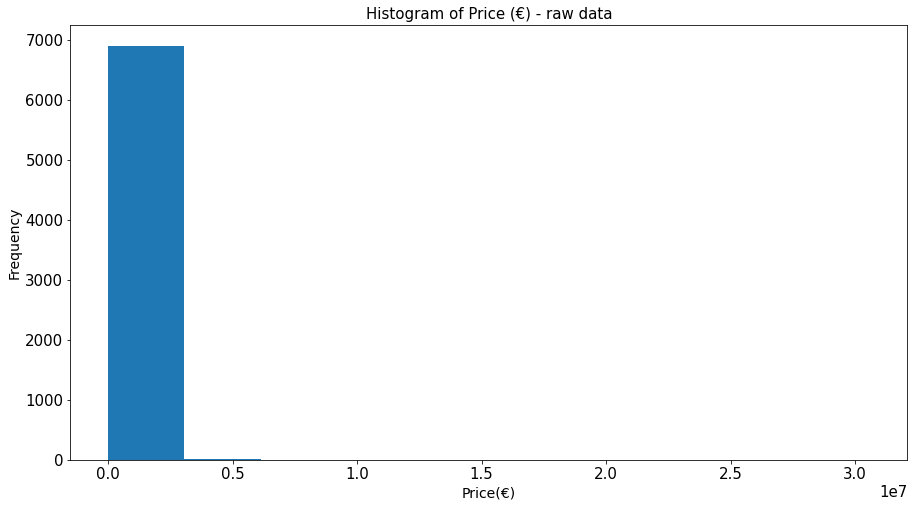

In [231]:
# plotting the price data
plt.figure(figsize=(15,8))
plt.title("Histogram of Price (€) - raw data", fontsize=15)
plt.xlabel("Price(€)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.hist(newTestDF['Price(€)'])
plt.show()

Clearly the dataset is being impacted by a few large values which will need to be removed. This is an unfortunate step to have to carry out and a limitation of the modelling. Clearly however properties selling in the millions are quite unique and have completely different characteristics that could not possibly be captured by the data we have available.

In [232]:
# set a log price column from the Price(€) column
newTestDF['logPrice'] = newTestDF['Price(€)'].apply(lambda row: np.log(row))
newTestDF['logPrice'] = newTestDF['logPrice'].astype(float)

In [233]:
# create a list of all counties
allcounties = newTestDF['County'].unique().tolist()

# initialise counter to see how many prices removed
pricecounter = 0
# loop through county list
for county in allcounties:
    # create a new dataframe for county
    subdataframe = newTestDF[newTestDF['County'].isin([county])]
    # iterate through this dataframe
    for index, row in subdataframe.iterrows():
        # check if log price is above 2 standard deviations above the mean
        if (row['logPrice'] > (subdataframe["logPrice"].mean() + 2*subdataframe["logPrice"].std())) or (row['logPrice'] < (subdataframe["logPrice"].mean() - 2*subdataframe["logPrice"].std())):
            # apply change to dfclean, not new dataframe
            newTestDF.loc[index,'logPrice'] = np.nan
            pricecounter += 1

# set Price(€) to exponent of what is left of logPrice column
newTestDF['Price(€)'] = newTestDF['logPrice'].apply(lambda row: np.exp(row))

# no need for logPrice column any more
newTestDF.drop('logPrice', axis=1, inplace=True)

print(pricecounter, "prices of outliers removed from price column.")

# drop rows without a Price(€)
newTestDF = newTestDF.dropna(subset=['Price(€)'])

341 prices of outliers removed from price column.


In [234]:
UpdatedPredictionsNewDataset = linreg.predict(newTestDF[predictorsNewDataset])

In [235]:
print("\u0332".join("Regression Evaluation Measures for new dataset"))
RegressionMetrics(newTestDF[target], UpdatedPredictionsNewDataset, predictorsNew, newTestDF.shape[0])

R̲e̲g̲r̲e̲s̲s̲i̲o̲n̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲a̲s̲u̲r̲e̲s̲ ̲f̲o̲r̲ ̲n̲e̲w̲ ̲d̲a̲t̲a̲s̲e̲t
MAE: 101627.64861021806
RMSE: 151040.8457870521
R2: 0.35075647814873545
Adjusted R2: 0.34588839359315593


In [236]:
# conducting cross validation
kfoldNew = cross_validate(LinearRegression(), newTestDF[predictorsNewDataset], newTestDF[target], scoring=testMetrics, cv=10)

In [237]:
df_cross_validate_new = pd.DataFrame()
df_cross_validate_new['Fold'] = [x for x in range(1,11)]
df_cross_validate_new['MAE'] = -kfoldNew['test_neg_mean_absolute_error']
df_cross_validate_new['RMSE'] = -kfoldNew['test_neg_mean_squared_error']
df_cross_validate_new['RMSE'] = df_cross_validate_new['RMSE'].apply(lambda val: math.sqrt(val))
df_cross_validate_new['R2'] = kfoldNew['test_r2']

ave_row_lin_reg_new = {'Fold':'Average', 'MAE':df_cross_validate_new['MAE'].mean(), 'RMSE':df_cross_validate_new['RMSE'].mean(),
           'R2':df_cross_validate_new['R2'].mean()}

df_cross_validate_new = df_cross_validate_new.append(ave_row_lin_reg_new, ignore_index=True)
df_cross_validate_new =df_cross_validate_new.style.apply(highlight_last)

df_cross_validate_new

,Fold,MAE,RMSE,R2
0,1,102860.805675,154914.983761,0.337684
1,2,116615.077299,166181.726303,0.317247
2,3,105709.768392,153582.028645,0.372309
3,4,109254.738633,157786.186955,0.388519
4,5,101790.849423,140510.556183,0.403699
5,6,100919.730182,139859.279701,0.399396
6,7,99128.518769,140281.327827,0.427528
7,8,108342.218030,147697.629944,0.291107
8,9,102715.960000,144778.872830,0.355288
9,10,97832.933450,140530.428758,0.386830


<b>Discussion of Findings</b>
- For a completely unseen dataset, and one that has a completely different distribution in terms of timing, the model has generalised very well in my opinion.
- Given the distribution of the data is only in Q1 of 2022, it gives me further reassurance that I chose the correct model (aside from it being the best performing one in any case). A huge level of importance was given to the quarter feature in both the Decision Tree and Random Forest models. This would have left a huge number of paths unused, and the model only able to predict a subset of the information it had learned. Clearly with the Linear Regression model it will always have the same value for one of the features, however all others will be applied differently and can allow for the appropriate level of differentiation through these.
- The R<sup>2</sup> in the Cross Validation is not that far from that seen in the Cross Validation of the Test Set initially of 0.40. The RMSE has ticked up a bit implying greater outliers, as well as the MAE, implying more errors in the residuals generally speaking, however this is still good performance all things considered. 
- Having seen already how poorly a model that predicts the mean performs, it is a good to see great improvement on this.
- Overall, it is somewhat disappointing not to have more granular information on aspects relating specifically to a proeprty, such as its size, condition etc. I believe a model including this type of data could be the only true possibility of obtaining greater accuracy.